---

# 1. Objetivo

El propósito de esta tarea es comparar el desempeño de arquitecturas de tipo encoder (modelos BERT ajustados con una cabeza de clasificación) y decoder (modelos de lenguaje autoregresivos mediante prompting sin ajuste de parámetros) en tareas de clasificación de texto.

Utilizarán los mismos conjuntos de datos empleados en tareas previas: 20Newsgroups para clasificación multiclase y Multi-Domain Sentiment Dataset para análisis de sentimiento.

Esta comparación permitirá analizar los límites, ventajas y desventajas de cada enfoque bajo restricciones computacionales razonables.

---

## 1.1. Instrucciones Generales

- ~~Utilice Jupyter Notebooks para el desarrollo de la tarea.~~
- ~~Incluya docstrings detallados en todas las clases, funciones y métodos.~~
- Ejecu­te todos los bloques de código y asegúrese de incluir los resultados en la entrega.
- Presente un informe en PDF que resuma la metodología, resultados y análisis comparativo.
- ~~Pueden realizar en grupos de hasta 4 personas~~

In [1]:
from typing import List, Dict, Optional, Tuple, Any, Union
import re, json, torch, pandas as pd, time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, PreTrainedModel
from tqdm.auto import tqdm
from sklearn.metrics import *
from IPython.display import display

/home/estudiante/tldr-uniandes/encoders-vs-decoders-classification/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Dividir datasets (Se usan los mismos que el notebook de finetuning de encoders)

Para ambos datasets, divida los datos en conjuntos de entrenamiento, validación y prueba siguiendo los mismos porcentajes que en las tareas anteriores.

### Datasets

- 20Newsgroups: Clasificación en 20 categorías temáticas.

- Multi-Domain Sentiment Dataset: Clasificación binaria de sentimiento (positivo/negativo) en cuatro categorías: Books, DVD, Electronics, Kitchen.

# 3. PROMPTS

- Para los modelos decoder, diseñe prompts efectivos y utilice las respuestas generadas para inferir la clase correspondiente.

* No es obligatorio ajustar los pesos de los modelos; puede utilizar técnicas de **prompting** para resolver las tareas de clasificación.

* Diseñe prompts específicos para cada tarea, justificando su redacción y estructura.

* Ejemplo de prompt para clasificación de sentimiento:

```
Review: "The battery life of this camera is amazing."
Sentiment (positive/negative):
```

* Ejemplo de prompt para clasificación de newsgroups:

```
Text: "The new Linux kernel has improved networking features."
Category:
```

## 3.1. Análisis Exploratorio de Datos (EDA) para usar las características en los prompts

El objetivo es entender la estructura, características y distribuciones de los datasets

In [2]:
!pip install pandas matplotlib seaborn

## Ruta archivos de training

In [2]:
NEWS_TRAIN: str = "/home/estudiante/punto2/mi-solution/news/test.csv"
MULTI_TRAIN: str = "/home/estudiante/punto2/mi-solution/mdsd/test.csv"

### EDA SCRIPT

In [3]:
def run_eda(RUTA_TRAIN_CSV: str, dataset_name: str):
    # Importar librerías necesarias
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from collections import Counter
    import re
    import warnings
    warnings.filterwarnings('ignore')

    # Configuración de visualización
    plt.rcParams['figure.figsize'] = (12, 8)
    sns.set_style("whitegrid")
    plt.rcParams['font.size'] = 10

    print("Librerías importadas exitosamente")

    # Cargar el dataset
    print("Cargando dataset...")
    df = pd.read_csv(RUTA_TRAIN_CSV)

    print(f"Dataset cargado: {len(df)} registros")
    print(f"Columnas: {list(df.columns)}")

    # Información básica del dataset
    print("\n=== INFORMACIÓN BÁSICA DEL DATASET ===")
    print(f"- Forma: {df.shape}")
    print(f"- Columnas: {list(df.columns)}")
    print(f"- Memoria usada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Información detallada
    print("\n=== INFORMACIÓN DETALLADA ===")
    print(df.info())

    # Verificar valores nulos
    print("\n=== VALORES NULOS ===")
    print(df.isnull().sum())
    print(f"\nTotal de valores nulos: {df.isnull().sum().sum()}")

    # Estadísticas descriptivas de columnas numéricas
    print("\n=== ESTADÍSTICAS DESCRIPTIVAS (COLUMNAS NUMÉRICAS) ===")
    print(df.describe())

    # Análisis de columnas categóricas
    print("\n=== ANÁLISIS DE COLUMNAS CATEGÓRICAS ===")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col != 'text':  # Excluir la columna de texto principal
            print(f"\n{col}:")
            print(f"- Valores únicos: {df[col].nunique()}")
            print(f"- Valores más frecuentes:")
            print(df[col].value_counts().head(10))

    # === analizar longitudes ===
    def analyze_text_lengths(df, text_column, dataset_name):
        print(f"\n=== ANÁLISIS DE LONGITUDES - {dataset_name.upper()} ===")
        
        char_lengths = df[text_column].str.len()
        word_lengths = df[text_column].str.split().str.len()
        sentence_lengths = df[text_column].str.split(r'[.!?]+').str.len()

        # prints sin tocar (pego literal)
        print(f"\nLongitud en caracteres:")
        print(f"- Mínimo: {char_lengths.min():,}")
        print(f"- Máximo: {char_lengths.max():,}")
        print(f"- Promedio: {char_lengths.mean():,.0f}")
        print(f"- Mediana: {char_lengths.median():,.0f}")
        print(f"- Desviación estándar: {char_lengths.std():,.0f}")
        print(f"- Q1: {char_lengths.quantile(0.25):,.0f}")
        print(f"- Q3: {char_lengths.quantile(0.75):,.0f}")

        print(f"\nLongitud en palabras:")
        print(f"- Mínimo: {word_lengths.min():,}")
        print(f"- Máximo: {word_lengths.max():,}")
        print(f"- Promedio: {word_lengths.mean():,.0f}")
        print(f"- Mediana: {word_lengths.median():,.0f}")
        print(f"- Desviación estándar: {word_lengths.std():,.0f}")
        print(f"- Q1: {word_lengths.quantile(0.25):,.0f}")
        print(f"- Q3: {word_lengths.quantile(0.75):,.0f}")

        print(f"\nNúmero de oraciones (aproximado):")
        print(f"- Mínimo: {sentence_lengths.min():,}")
        print(f"- Máximo: {sentence_lengths.max():,}")
        print(f"- Promedio: {sentence_lengths.mean():,.0f}")
        print(f"- Mediana: {sentence_lengths.median():,.0f}")

        return char_lengths, word_lengths, sentence_lengths

    char_lens, word_lens, sent_lens = analyze_text_lengths(df, 'text', dataset_name)

    # Visualización (SIN savefig → show)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes[0,0].hist(word_lens, bins=50, alpha=0.7, edgecolor='black')
    axes[0,1].hist(char_lens, bins=50, alpha=0.7, edgecolor='black')
    axes[1,0].boxplot([word_lens], labels=['Palabras'])
    axes[1,1].boxplot([char_lens], labels=['Caracteres'])
    plt.tight_layout()
    plt.show()

        # Análisis de distribución de etiquetas
    if 'label_name' in df.columns:
        print("\n=== ANÁLISIS DE DISTRIBUCIÓN DE ETIQUETAS ===")
        label_counts = df['label_name'].value_counts()
        print(f"\nTotal de etiquetas únicas: {df['label_name'].nunique()}")
        print(f"\nDistribución de etiquetas:")
        print(label_counts)
        
        # Visualización de distribución de etiquetas
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Gráfico de barras horizontal
        top_labels = label_counts.head(20)  # Top 20 etiquetas
        axes[0].barh(range(len(top_labels)), top_labels.values)
        axes[0].set_yticks(range(len(top_labels)))
        axes[0].set_yticklabels(top_labels.index)
        axes[0].set_xlabel('Frecuencia')
        axes[0].set_title('Top 20 Etiquetas Más Frecuentes', fontsize=12, fontweight='bold')
        axes[0].invert_yaxis()
        
        # Gráfico de pastel (solo top 10)
        top_10_labels = label_counts.head(10)
        other_count = label_counts.tail(-10).sum()
        if other_count > 0:
            pie_data = list(top_10_labels.values) + [other_count]
            pie_labels = list(top_10_labels.index) + ['Otros']
        else:
            pie_data = top_10_labels.values
            pie_labels = top_10_labels.index
        
        axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
        axes[1].set_title('Distribución de Etiquetas (Top 10)', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

    # Análisis de balance de clases
    if 'label' in df.columns:
        print("\n=== ANÁLISIS DE BALANCE DE CLASES ===")
        label_dist = df['label'].value_counts().sort_index()
        print(f"\nDistribución de clases (label numérico):")
        print(label_dist)
        
        # Calcular balance
        class_balance = label_dist / len(df)
        print(f"\nBalance de clases:")
        for label, balance in class_balance.items():
            print(f"- Clase {label}: {balance:.2%}")
        
        # Verificar si está balanceado
        balance_ratio = class_balance.min() / class_balance.max()
        print(f"\nRatio de balance (min/max): {balance_ratio:.3f}")
        if balance_ratio > 0.8:
            print("✓ Dataset relativamente balanceado")
        elif balance_ratio > 0.5:
            print("⚠ Dataset moderadamente desbalanceado")
        else:
            print("✗ Dataset muy desbalanceado - considerar técnicas de balanceo")

    # Análisis de splits
    if 'split' in df.columns:
        print("\n=== ANÁLISIS DE SPLITS ===")
        split_counts = df['split'].value_counts()
        print(f"\nDistribución de splits:")
        print(split_counts)
        print(f"\nPorcentajes:")
        for split, count in split_counts.items():
            print(f"- {split}: {count/len(df):.2%}")

    # Análisis de patrones de texto
    def analyze_text_patterns(df, text_column, dataset_name):
        """Analiza patrones comunes en el texto"""
        print(f"\n=== ANÁLISIS DE PATRONES - {dataset_name.upper()} ===")
        
        # Muestra para análisis (si el dataset es muy grande)
        sample_size = min(10000, len(df))
        sample_df = df.sample(n=sample_size, random_state=42) if len(df) > sample_size else df
        
        # Combinar una muestra del texto
        sample_text = ' '.join(sample_df[text_column].astype(str).head(1000))
        
        # Patrones comunes
        patterns = {
            'Emails': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
            'URLs': r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
            'Números': r'\b\d+\b',
            'Palabras en mayúsculas': r'\b[A-Z]{3,}\b',
            'Puntuación múltiple': r'[!?]{2,}',
        }
        
        for pattern_name, pattern in patterns.items():
            matches = re.findall(pattern, sample_text)
            print(f"- {pattern_name}: {len(matches)} ocurrencias en muestra")
            if matches and len(matches) > 0 and len(matches) <= 10:
                examples = list(set(matches))[:5]
                print(f"  Ejemplos: {', '.join(examples)}")
        
        # Análisis de palabras más comunes
        words = re.findall(r'\b[a-zA-Z]{3,}\b', sample_text.lower())
        word_freq = Counter(words)
        print(f"\nPalabras más comunes (top 20):")
        for word, freq in word_freq.most_common(20):
            print(f"- {word}: {freq:,}")
        
        return word_freq

    # Analizar patrones de texto
    text_patterns = analyze_text_patterns(df, 'text', 'Textos')

    # Análisis de calidad de datos
    def analyze_data_quality():
        """Analiza la calidad de los datos y detecta posibles problemas"""
        print("\n=== ANÁLISIS DE CALIDAD DE DATOS ===")
        
        # 1. Verificar duplicados
        print("\n1. Duplicados:")
        text_dups = df.duplicated('text').sum()
        total_dups = df.duplicated().sum()
        print(f"- Textos duplicados: {text_dups}")
        print(f"- Filas completamente duplicadas: {total_dups}")
        if text_dups > 0:
            print(f"  Porcentaje de duplicados: {text_dups/len(df):.2%}")
        
        # 2. Textos muy cortos o muy largos (outliers)
        print("\n2. Outliers de longitud:")
        
        # Percentiles para identificar outliers
        word_q1 = word_lens.quantile(0.25)
        word_q3 = word_lens.quantile(0.75)
        word_iqr = word_q3 - word_q1
        word_outliers = ((word_lens < (word_q1 - 1.5 * word_iqr)) | 
                         (word_lens > (word_q3 + 1.5 * word_iqr))).sum()
        
        char_q1 = char_lens.quantile(0.25)
        char_q3 = char_lens.quantile(0.75)
        char_iqr = char_q3 - char_q1
        char_outliers = ((char_lens < (char_q1 - 1.5 * char_iqr)) | 
                         (char_lens > (char_q3 + 1.5 * char_iqr))).sum()
        
        print(f"- Outliers en palabras: {word_outliers} ({word_outliers/len(df):.2%})")
        print(f"- Outliers en caracteres: {char_outliers} ({char_outliers/len(df):.2%})")
        
        # 3. Textos extremadamente cortos
        print("\n3. Textos extremadamente cortos:")
        very_short_words = (word_lens < 10).sum()
        very_short_chars = (char_lens < 50).sum()
        
        print(f"- Textos con menos de 10 palabras: {very_short_words}")
        print(f"- Textos con menos de 50 caracteres: {very_short_chars}")
        
        # 4. Textos vacíos o casi vacíos
        print("\n4. Textos vacíos o problemáticos:")
        empty_texts = (df['text'].isna() | (df['text'].str.strip() == '')).sum()
        print(f"- Textos vacíos o nulos: {empty_texts}")
        
        return {
            'duplicates': text_dups,
            'word_outliers': word_outliers,
            'char_outliers': char_outliers,
            'very_short': very_short_words,
            'empty': empty_texts
        }

    quality_metrics = analyze_data_quality()

    # Ejemplos representativos
    def show_examples():
        """Muestra ejemplos de diferentes longitudes"""
        print("\n=== EJEMPLOS REPRESENTATIVOS ===")
        
        # Encontrar ejemplos de diferentes longitudes
        short_idx = word_lens.idxmin()  # Más corto
        long_idx = word_lens.idxmax()   # Más largo
        median_idx = (word_lens - word_lens.median()).abs().idxmin()  # Mediano
        
        examples = [
            (short_idx, "MÁS CORTO"),
            (median_idx, "MEDIANO"),
            (long_idx, "MÁS LARGO")
        ]
        
        for idx, label in examples:
            text = df.iloc[idx]['text']
            words = len(text.split())
            chars = len(text)
            label_name = df.iloc[idx].get('label_name', 'N/A')
            
            print(f"\n{label} (Índice: {idx}):")
            print(f"- Palabras: {words:,}")
            print(f"- Caracteres: {chars:,}")
            print(f"- Etiqueta: {label_name}")
            print(f"- Inicio del texto: {text[:200]}...")
            print("-" * 80)

    show_examples()

    # Análisis de correlación entre longitud y etiquetas
    if 'label_name' in df.columns:
        print("\n=== ANÁLISIS DE CORRELACIÓN LONGITUD-ETIQUETA ===")
        
        # Agregar columnas de longitud
        df_analysis = df.copy()
        df_analysis['word_count'] = word_lens
        df_analysis['char_count'] = char_lens
        
        # Estadísticas por etiqueta
        label_stats = df_analysis.groupby('label_name').agg({
            'word_count': ['mean', 'median', 'std', 'count'],
            'char_count': ['mean', 'median']
        }).round(2)
        
        print("\nEstadísticas de longitud por etiqueta:")
        print(label_stats.head(20))
        
        # Visualización de longitud por etiqueta (top 10)
        if df['label_name'].nunique() <= 20:
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            top_labels = df['label_name'].value_counts().head(10).index
            
            # Box plot de palabras por etiqueta
            data_to_plot = [df_analysis[df_analysis['label_name'] == label]['word_count'].values 
                            for label in top_labels]
            axes[0].boxplot(data_to_plot, labels=top_labels)
            axes[0].set_title('Distribución de Palabras por Etiqueta (Top 10)', 
                             fontsize=12, fontweight='bold')
            axes[0].set_ylabel('Número de palabras')
            axes[0].tick_params(axis='x', rotation=45)
            
            # Promedio de palabras por etiqueta
            avg_words = df_analysis.groupby('label_name')['word_count'].mean().sort_values(ascending=False).head(10)
            axes[1].barh(range(len(avg_words)), avg_words.values)
            axes[1].set_yticks(range(len(avg_words)))
            axes[1].set_yticklabels(avg_words.index)
            axes[1].set_xlabel('Promedio de palabras')
            axes[1].set_title('Promedio de Palabras por Etiqueta (Top 10)', fontsize=12, fontweight='bold')
            axes[1].invert_yaxis()
            
            plt.tight_layout()
            plt.show()

    # Resumen final
    print("\n" + "="*70)
    print("RESUMEN FINAL DEL ANÁLISIS EXPLORATORIO")
    print("="*70)

    print(f"""
HALLAZGOS PRINCIPALES:

1. ESTRUCTURA DE DATOS:
   - Total de registros: {len(df):,}
   - Columnas: {len(df.columns)}
   - Memoria usada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB

2. CARACTERÍSTICAS DE LONGITUD:
   - Palabras: Promedio {word_lens.mean():.0f}, Mediana {word_lens.median():.0f}
   - Caracteres: Promedio {char_lens.mean():.0f}, Mediana {char_lens.median():.0f}
   - Rango: {word_lens.min():,} - {word_lens.max():,} palabras

3. DISTRIBUCIÓN DE ETIQUETAS:
   - Etiquetas únicas: {df['label_name'].nunique() if 'label_name' in df.columns else 'N/A'}
   - Balance: {'Balanceado' if 'label' in df.columns and (df['label'].value_counts().min() / df['label'].value_counts().max() > 0.8) else 'Desbalanceado'}

4. CALIDAD DE DATOS:
   - Duplicados: {quality_metrics['duplicates']} ({quality_metrics['duplicates']/len(df):.2%})
   - Outliers: {quality_metrics['word_outliers']} ({quality_metrics['word_outliers']/len(df):.2%})
   - Textos muy cortos: {quality_metrics['very_short']}
   - Textos vacíos: {quality_metrics['empty']}

5. RECOMENDACIONES:
   - {'Considerar balanceo de clases' if 'label' in df.columns and (df['label'].value_counts().min() / df['label'].value_counts().max() < 0.5) else 'Dataset relativamente balanceado'}
   - {'Limpiar duplicados' if quality_metrics['duplicates'] > 0 else 'No hay duplicados significativos'}
   - {'Revisar textos muy cortos' if quality_metrics['very_short'] > len(df) * 0.01 else 'Textos de longitud adecuada'}
""")

    print("\nAnálisis completado exitosamente!")
    print("Gráficos mostrados en notebook.")

    print("\n=== FIN EDA", dataset_name, "===")

### 3.1.1. 20 newsgroup EDA

Librerías importadas exitosamente
Cargando dataset...
Dataset cargado: 5654 registros
Columnas: ['text', 'label_name', 'original_split', 'label', 'split']

=== INFORMACIÓN BÁSICA DEL DATASET ===
- Forma: (5654, 5)
- Columnas: ['text', 'label_name', 'original_split', 'label', 'split']
- Memoria usada: 11.85 MB

=== INFORMACIÓN DETALLADA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            5654 non-null   object
 1   label_name      5654 non-null   object
 2   original_split  5654 non-null   object
 3   label           5654 non-null   int64 
 4   split           5654 non-null   object
dtypes: int64(1), object(4)
memory usage: 221.0+ KB
None

=== VALORES NULOS ===
text              0
label_name        0
original_split    0
label             0
split             0
dtype: int64

Total de valores nulos: 0

=== ESTADÍSTICAS DESCRI

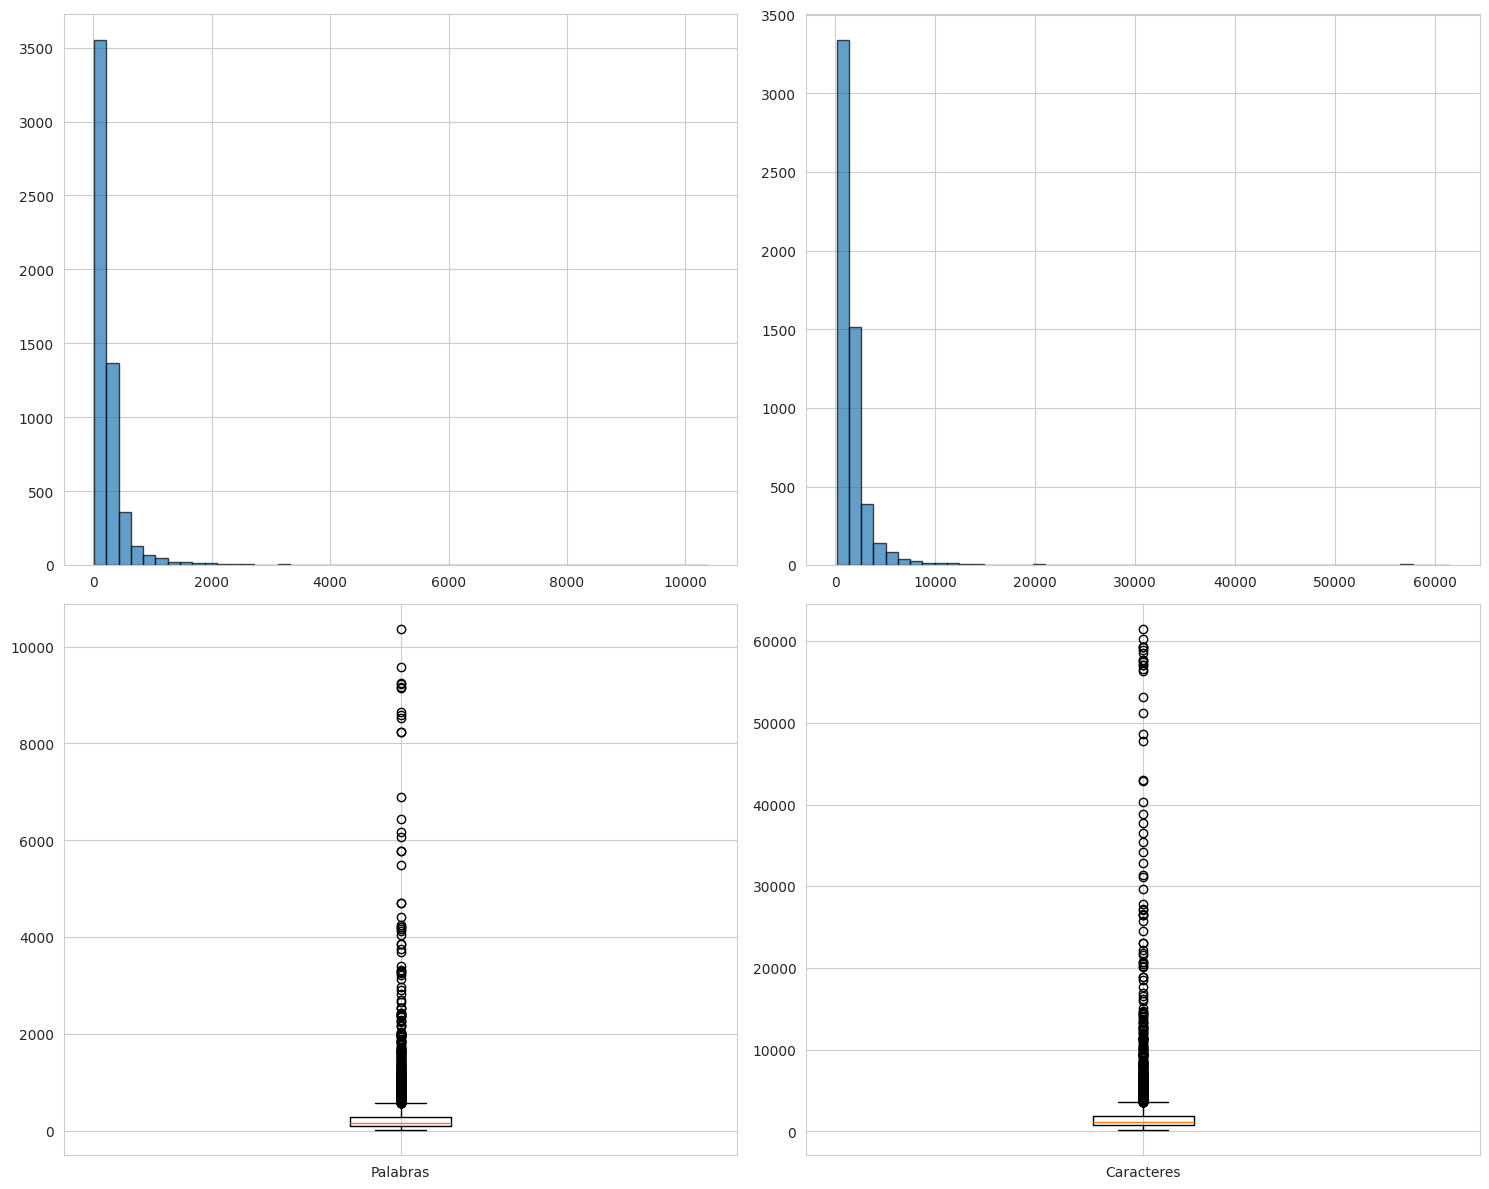


=== ANÁLISIS DE DISTRIBUCIÓN DE ETIQUETAS ===

Total de etiquetas únicas: 20

Distribución de etiquetas:
label_name
rec.sport.hockey            300
rec.motorcycles             299
soc.religion.christian      299
rec.sport.baseball          298
rec.autos                   297
sci.crypt                   297
sci.med                     297
sci.space                   296
comp.os.ms-windows.misc     296
comp.windows.x              296
comp.sys.ibm.pc.hardware    295
sci.electronics             295
misc.forsale                293
comp.graphics               292
comp.sys.mac.hardware       289
talk.politics.mideast       282
talk.politics.guns          273
alt.atheism                 240
talk.politics.misc          232
talk.religion.misc          188
Name: count, dtype: int64


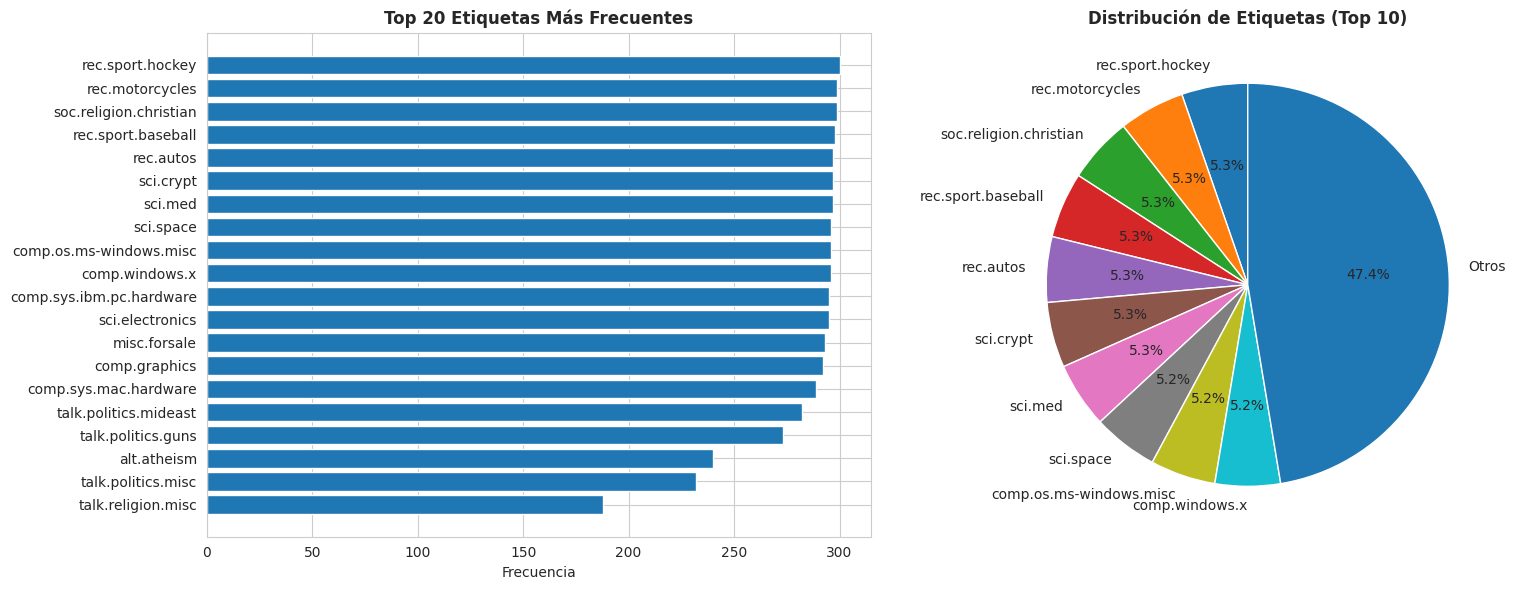


=== ANÁLISIS DE BALANCE DE CLASES ===

Distribución de clases (label numérico):
label
0     240
1     292
2     296
3     295
4     289
5     296
6     293
7     297
8     299
9     298
10    300
11    297
12    295
13    297
14    296
15    299
16    273
17    282
18    232
19    188
Name: count, dtype: int64

Balance de clases:
- Clase 0: 4.24%
- Clase 1: 5.16%
- Clase 2: 5.24%
- Clase 3: 5.22%
- Clase 4: 5.11%
- Clase 5: 5.24%
- Clase 6: 5.18%
- Clase 7: 5.25%
- Clase 8: 5.29%
- Clase 9: 5.27%
- Clase 10: 5.31%
- Clase 11: 5.25%
- Clase 12: 5.22%
- Clase 13: 5.25%
- Clase 14: 5.24%
- Clase 15: 5.29%
- Clase 16: 4.83%
- Clase 17: 4.99%
- Clase 18: 4.10%
- Clase 19: 3.33%

Ratio de balance (min/max): 0.627
⚠ Dataset moderadamente desbalanceado

=== ANÁLISIS DE SPLITS ===

Distribución de splits:
split
test    5654
Name: count, dtype: int64

Porcentajes:
- test: 100.00%

=== ANÁLISIS DE PATRONES - TEXTOS ===
- Emails: 3331 ocurrencias en muestra
- URLs: 0 ocurrencias en muestra
- Núme

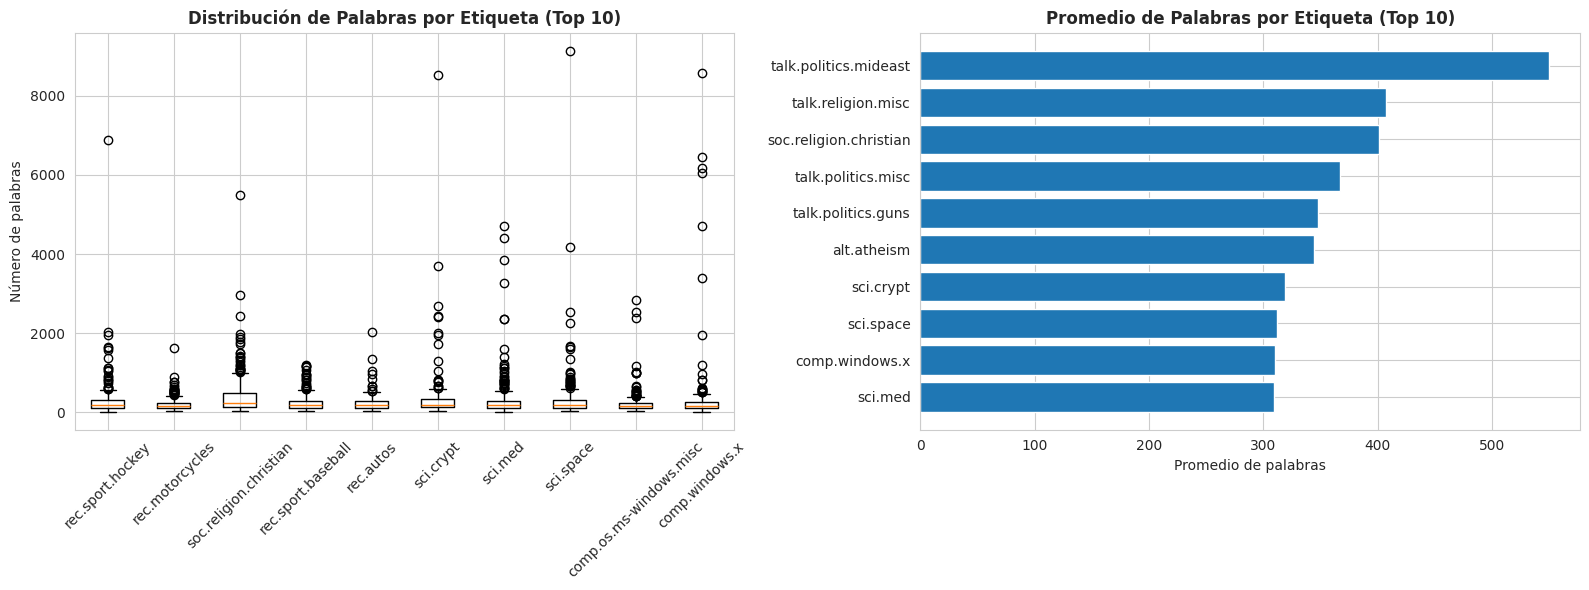


RESUMEN FINAL DEL ANÁLISIS EXPLORATORIO

HALLAZGOS PRINCIPALES:

1. ESTRUCTURA DE DATOS:
   - Total de registros: 5,654
   - Columnas: 5
   - Memoria usada: 11.93 MB

2. CARACTERÍSTICAS DE LONGITUD:
   - Palabras: Promedio 289, Mediana 173
   - Caracteres: Promedio 1938, Mediana 1163
   - Rango: 14 - 10,365 palabras

3. DISTRIBUCIÓN DE ETIQUETAS:
   - Etiquetas únicas: 20
   - Balance: Desbalanceado

4. CALIDAD DE DATOS:
   - Duplicados: 0 (0.00%)
   - Outliers: 450 (7.96%)
   - Textos muy cortos: 0
   - Textos vacíos: 0

5. RECOMENDACIONES:
   - Dataset relativamente balanceado
   - No hay duplicados significativos
   - Textos de longitud adecuada


Análisis completado exitosamente!
Gráficos mostrados en notebook.

=== FIN EDA 20ng ===


In [4]:
run_eda(NEWS_TRAIN, "20ng")

### 3.1.2. Multi-Domain Sentiment EDA

Librerías importadas exitosamente
Cargando dataset...
Dataset cargado: 4465 registros
Columnas: ['text', 'label', 'label_id']

=== INFORMACIÓN BÁSICA DEL DATASET ===
- Forma: (4465, 3)
- Columnas: ['text', 'label', 'label_id']
- Memoria usada: 11.34 MB

=== INFORMACIÓN DETALLADA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4465 entries, 0 to 4464
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      4465 non-null   object
 1   label     4465 non-null   object
 2   label_id  4465 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 104.8+ KB
None

=== VALORES NULOS ===
text        0
label       0
label_id    0
dtype: int64

Total de valores nulos: 0

=== ESTADÍSTICAS DESCRIPTIVAS (COLUMNAS NUMÉRICAS) ===
          label_id
count  4465.000000
mean      0.507055
std       0.500006
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000

=== ANÁLISIS DE COLUMNAS CATEG

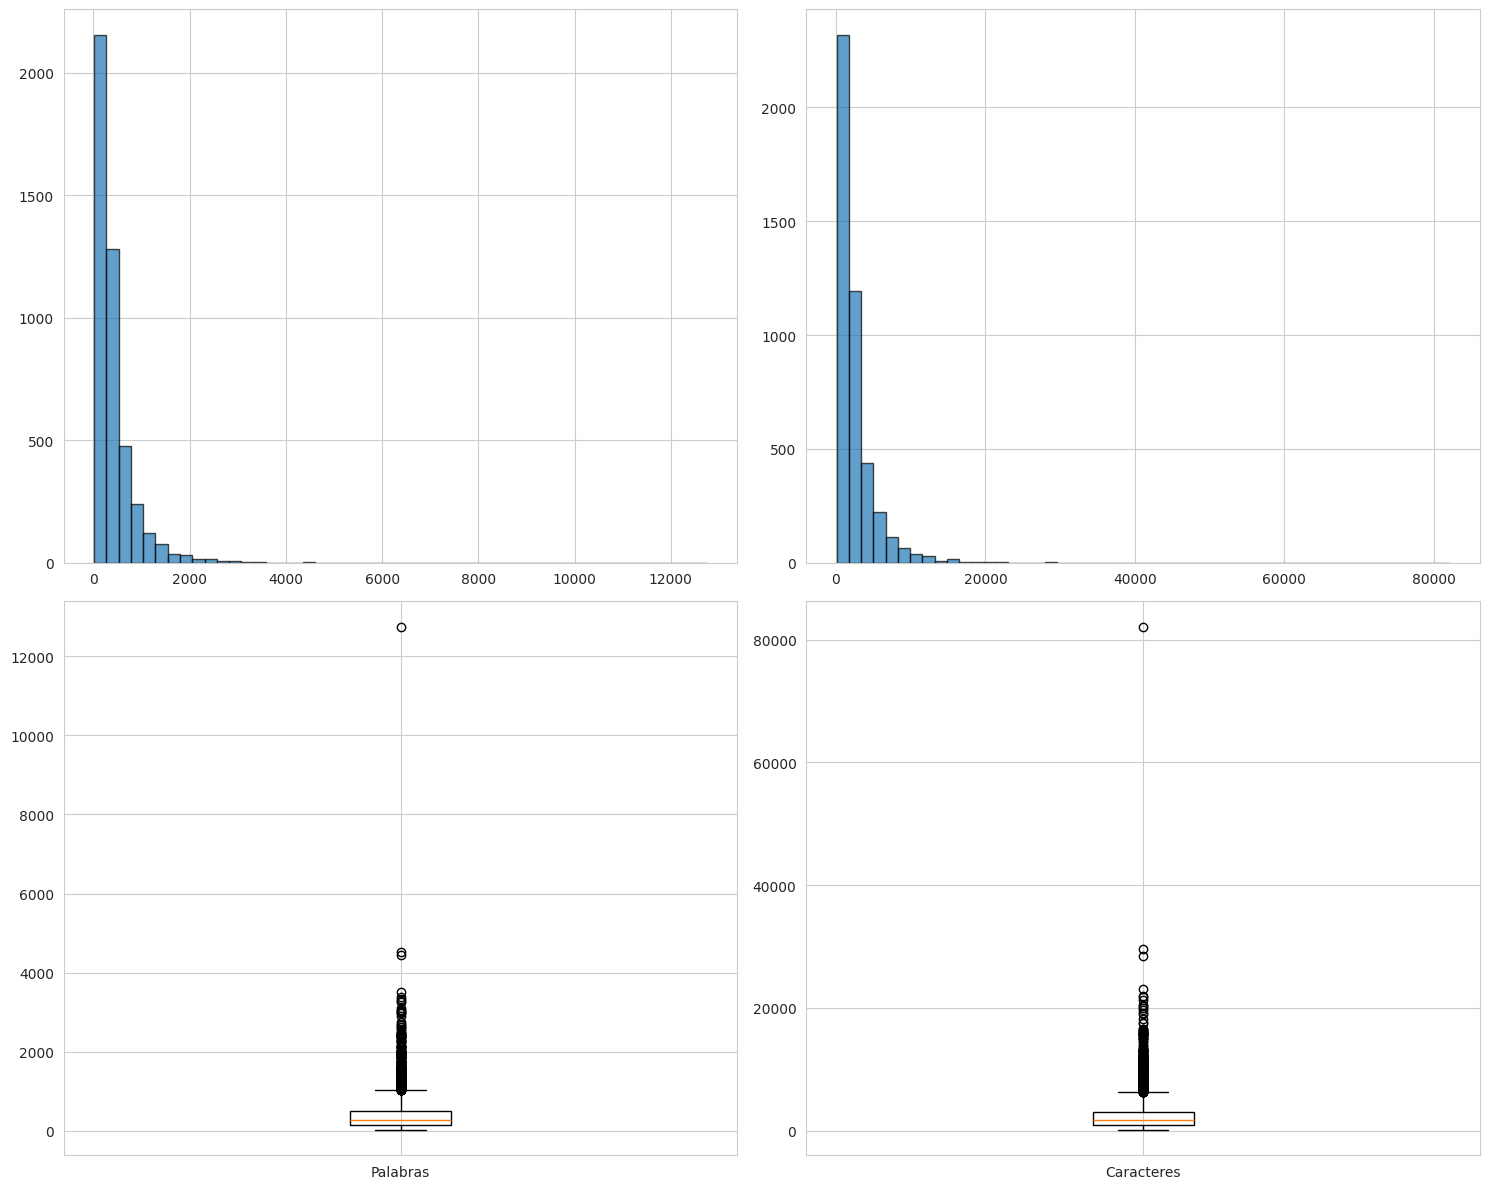


=== ANÁLISIS DE BALANCE DE CLASES ===

Distribución de clases (label numérico):
label
negative    2201
positive    2264
Name: count, dtype: int64

Balance de clases:
- Clase negative: 49.29%
- Clase positive: 50.71%

Ratio de balance (min/max): 0.972
✓ Dataset relativamente balanceado

=== ANÁLISIS DE PATRONES - TEXTOS ===
- Emails: 2 ocurrencias en muestra
  Ejemplos: meevan.fett@gmail.co
- URLs: 0 ocurrencias en muestra
- Números: 708 ocurrencias en muestra
- Palabras en mayúsculas: 0 ocurrencias en muestra
- Puntuación múltiple: 51 ocurrencias en muestra

Palabras más comunes (top 20):
- the: 13,483
- and: 8,494
- book: 6,360
- you: 3,706
- that: 3,481
- this: 3,357
- was: 3,249
- not: 3,096
- his: 2,514
- for: 2,417
- read: 2,031
- one: 1,905
- all: 1,886
- about: 1,795
- with: 1,778
- are: 1,644
- who: 1,607
- what: 1,600
- num: 1,579
- but: 1,534

=== ANÁLISIS DE CALIDAD DE DATOS ===

1. Duplicados:
- Textos duplicados: 380
- Filas completamente duplicadas: 380
  Porcentaje de d

In [5]:
run_eda(MULTI_TRAIN, "multi")

## 3.2 Prompts

### 3 prompts para 20 Newsgroups con base a su Estadistica Descriptiva

In [3]:
NEWS_LABELS: List[str] = [
"alt.atheism",
"comp.graphics",
"comp.os.ms-windows.misc",
"comp.sys.ibm.pc.hardware",
"comp.sys.mac.hardware",
"comp.windows.x",
"misc.forsale",
"rec.autos",
"rec.motorcycles",
"rec.sport.baseball",
"rec.sport.hockey",
"sci.crypt",
"sci.electronics",
"sci.med",
"sci.space",
"soc.religion.christian",
"talk.politics.guns",
"talk.politics.mideast",
"talk.politics.misc",
"talk.religion.misc"
]

NEWS_PROMPTS: Dict[int, str] = {

  1: """You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK:
Read the text. Decide ONLY the MAIN topical category of the body.
Focus on the dominant recurring theme (ignore tangents or mixed topics).

For disambiguation, silently apply these concise rules:

Computing:
• PC hardware → comp.sys.ibm.pc.hardware
• Mac hardware → comp.sys.mac.hardware
• X11 → comp.windows.x
• Windows (non-X11) → comp.os.ms-windows.misc
• graphics/rendering → comp.graphics

Science:
• electronics/EE → sci.electronics
• cryptography/security → sci.crypt
• medicine/healthcare → sci.med
• astronomy/spaceflight → sci.space

Recreation:
• cars → rec.autos
• motorcycles → rec.motorcycles
• baseball/hockey → rec.sport.baseball / rec.sport.hockey

Religion:
• Christian doctrine/worship → soc.religion.christian
• belief/atheism debate → alt.atheism
• other religion → talk.religion.misc

Politics:
• guns → talk.politics.guns
• Middle East → talk.politics.mideast
• otherwise → talk.politics.misc

Allowed labels (verbatim):
{labels}

TEXT:
{texto}

FINAL OUTPUT RULES (MANDATORY):
• Output must be EXACTLY one token from the allowed list above.
• NO quotes, NO punctuation, NO JSON, NO explanations.
• NO extra text, formatting, or justification.
• Output MUST match a label character-by-character.

If the text is unclear, choose the closest fitting label from the list.
Your entire reply must consist ONLY of that single label.""",


  2: """20 Newsgroups disambiguation — concise decision rules (apply silently).

Computing:
• PC hardware → comp.sys.ibm.pc.hardware
• Mac hardware → comp.sys.mac.hardware
• X11 → comp.windows.x
• Windows (non-X11) → comp.os.ms-windows.misc
• graphics/rendering → comp.graphics

Science:
• electronics/EE → sci.electronics
• cryptography/security → sci.crypt
• medicine/healthcare → sci.med
• astronomy/spaceflight → sci.space

Recreation:
• cars → rec.autos
• motorcycles → rec.motorcycles
• baseball/hockey → rec.sport.baseball / rec.sport.hockey

Religion:
• Christian doctrine/worship → soc.religion.christian
• belief/atheism debate → alt.atheism
• other religion → talk.religion.misc

Politics:
• guns → talk.politics.guns
• Middle East → talk.politics.mideast
• otherwise → talk.politics.misc

Ignore headers, signatures, and quoted replies.

Allowed labels (verbatim):
{labels}

TEXT:
{texto}

FINAL OUTPUT RULES (MANDATORY):
→ Respond with EXACTLY one of the allowed labels above.
→ No JSON. No quotes. No punctuation. No explanations.
→ Output ONLY the label itself — nothing before or after.""",


  3: """You are the Gatekeeper of *Newsgroup City* — each message must enter its correct District.
Use the examples below to learn the badges of every district (few-shot learning).

Allowed district badges (verbatim):
{labels}

Examples (one per district):
Text: "Debating God's existence and atheism arguments."
Badge: alt.atheism

Text: "OpenGL rendering artifacts; Phong vs Gouraud shading."
Badge: comp.graphics

Text: "Windows driver issues on 3.1 system."
Badge: comp.os.ms-windows.misc

Text: "IRQ conflicts on 486 motherboard."
Badge: comp.sys.ibm.pc.hardware

Text: "Mac LC logic board problem with ADB devices."
Badge: comp.sys.mac.hardware

Text: "Xlib keyboard mappings and xterm resources."
Badge: comp.windows.x

Text: "Selling used modem, $50 shipped OBO."
Badge: misc.forsale

Text: "Oil change and tire pressure for Honda Civic."
Badge: rec.autos

Text: "Helmet recommendations for highway touring."
Badge: rec.motorcycles

Text: "Pitcher stats and batting averages discussion."
Badge: rec.sport.baseball

Text: "Goalie saves and playoffs predictions."
Badge: rec.sport.hockey

Text: "RSA encryption key length and factoring attacks."
Badge: sci.crypt

Text: "Capacitor value in RC circuits; voltage drop."
Badge: sci.electronics

Text: "Vaccine trial outcomes; side effects reported."
Badge: sci.med

Text: "Hubble telescope imagery and shuttle missions."
Badge: sci.space

Text: "Meaning of grace and Christian doctrine."
Badge: soc.religion.christian

Text: "Gun control laws and Second Amendment debate."
Badge: talk.politics.guns

Text: "Israel–Palestine peace process updates."
Badge: talk.politics.mideast

Text: "Upcoming elections and budget bill discussions."
Badge: talk.politics.misc

Text: "Comparing Hindu and Buddhist rituals."
Badge: talk.religion.misc

--- Supplementary district guidance (apply silently) ---
Computing: comp.* labels focus on hardware/software issues.
Science: sci.* labels cover research, technology, and discovery.
Recreation: rec.* labels are hobbies or sports.
Religion & Politics: talk.* and soc.* labels concern belief or policy debate.
Marketplace: misc.forsale = classifieds/trades.

Now judge the following traveler and give them **their badge**.

TEXT:
{texto}

⚔️ OUTPUT RULES (MANDATORY):
• Output ONLY the badge name — one exact label from the list above.
• NO JSON, NO punctuation, NO explanations, NO extra words.
• The badge (label) must be typed *exactly* as listed.
• Any deviation disqualifies the entry."""
}

### 3 prompts para Multi-Domain Sentiment con base a su Estadistica Descriptiva

In [4]:
SENTIMENT_PROMPTS: Dict[int, str] = {
  1: """Binary sentiment for multi-domain PRODUCT REVIEWS (books, dvd, kitchen, electronics).

Guidance (do NOT print it):
• books: plot, characters, writing, author, chapters, pacing
• dvd: movie, acting, picture/sound quality, scenes, director's cut
• kitchen: appliance, durability, leakage, blades, cleaning
• electronics: battery, warranty, performance, build, connectivity

Rules:
• positive = overall endorsement / works / good value
• negative = defect / disappointment / poor value
• Handle negation and mild praise (e.g., "not bad" → mild positive).
• Ignore repetition, elongation, or emphasis (e.g., "gooood", duplicated words).

Output exactly one token:
positive
negative

TEXT:
{texto}

Answer:""",

  2: """Sentiment checklist (apply silently; no explanations):

(1) Outcome:
    success/enjoyment/recommend → positive
    failure/return/refund/disappointment → negative
(2) Quality:
    reliable/effective/durable → positive
    broken/defective/doesn't work/leaks → negative
(3) Value:
    worth the price → positive
    waste of money → negative
(4) Language phenomena:
    handle negation/irony ("not bad", "hardly works"); ignore repeated tokens/typos.

Return exactly one:
positive
negative

TEXT:
{texto}

Label:""",

  3: """Contrastive sentiment decision (do NOT reveal reasoning):

Privately weigh PROS vs CONS across the whole review (long texts common).
If pros dominate → positive; else → negative.
Be robust to domain-specific cues (books/dvd content vs kitchen/electronics defects) and to duplicated sentences.

Valid outputs:
positive
negative

TEXT:
{texto}

Output ONLY the label:"""
}

## Modelos usados
Use al menos dos modelos generativos autoregresivos de código abierto con menos de 7 mil millones de parámetros (**7B**), tales como **GPT-2, GPT-Neo-1.3B, OPT-1.3B, Llama 2 7B** o equivalentes.

In [9]:
!pip install -U transformers accelerate bitsandbytes

In [5]:
# ---- Modelos a evaluar (4-bit) ----
MODELS: List[str] = [
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/gemma-2-9b-it-bnb-4bit",
]

### Porque se escogen esos modelos?

Dentro de los leaderboards estos modelos tienen los mejores resultados bajo los siguientes filtros definidos:

- modelos generativos autoregresivos de código abierto, text-only y sin chain-of-thought
- versiones instruct / chat
- cuantizados a 4-bits (para mejor velocidad en inference)
- ≤ 7B parámetros

Leaderboards:

* [https://lmarena.ai/leaderboard/text](https://lmarena.ai/leaderboard/text)
* [https://openlm.ai/chatbot-arena/](https://openlm.ai/chatbot-arena/)
* [https://maxim-saplin.github.io/llm_chess/](https://maxim-saplin.github.io/llm_chess/)
* [https://artificialanalysis.ai/](https://artificialanalysis.ai/)
* [https://arcprize.org/](https://arcprize.org/)

# Resultados

Reporte y compare los resultados en términos de **precisión**, **recall**, **F1 (macro y micro)**, y **accuracy**.

In [11]:
!pip install scikit-learn

## Ruta archivos de test

In [6]:
NEWS_TEST: str = "/home/estudiante/punto2/mi-solution/news/test.csv"
MULTI_TEST: str = "/home/estudiante/punto2/mi-solution/mdsd/test.csv"

### Utils

In [7]:
# ======================================================================
# CONFIG GLOBAL
# ======================================================================
GOLD_COL: str = "label_name"
"""Nombre de la columna para las etiquetas verdaderas en el dataset de Newsgroups."""
TEXT_COL: str = "text"
"""Nombre de la columna para el texto de entrada en los datasets."""
GEN_KW: Dict[str, Union[int, bool]] = dict(max_new_tokens=24, do_sample=False)
"""Parámetros de generación para la inferencia del modelo. Determinista (sin muestreo)."""
SMOKE_LIMIT: Optional[int] = None
"""Limita el número de ejemplos de prueba para pruebas rápidas. Establecer a None para usar el conjunto de prueba completo."""
HEADER_PREFIXES: Tuple[str, ...] = ("from:", "subject:", "organization:", "reply-to:", "lines:", "nntp", "keywords:")
"""Prefijos de encabezados de email para filtrar al limpiar el texto."""

# ======================================================================
# strip / parser
# ======================================================================
def strip_headers_quotes(x: str, max_chars: int = 1500) -> str:
    """
    Elimina encabezados de email, respuestas citadas y firmas del texto.
    
    Filtra líneas que comienzan con encabezados comunes de email (From:, Subject:, etc.),
    respuestas citadas (líneas que comienzan con '>' o 'In article'), y líneas vacías.
    Retorna el texto del cuerpo limpio truncado a max_chars caracteres.
    
    Args:
        x: Cadena de texto de entrada (típicamente un mensaje de email/newsgroup)
        max_chars: Número máximo de caracteres a retornar (por defecto: 1500)
    
    Returns:
        Cadena de texto limpia con encabezados y citas eliminadas, truncada a max_chars
    """
    lines = []
    for ln in x.splitlines():
        l = ln.strip()
        if not l:
            continue
        ll = l.lower()
        if ll.startswith(HEADER_PREFIXES) or ll.startswith(">") or ll.startswith("in article"):
            continue
        lines.append(l)
    body = "\n".join(lines)
    return body[:max_chars]     # cabeza del cuerpo (NO cola)

def extract_label(raw: str, allowed_labels: List[str]) -> Optional[str]:
    """
    Extrae una etiqueta válida de la salida cruda del modelo.
    
    Intenta múltiples estrategias para extraer una etiqueta válida:
    1. Parsear formato JSON (busca claves "label", "Label", "category", "Category")
    2. Coincidencia exacta sensible a mayúsculas en tokens
    3. Coincidencia sin distinguir mayúsculas en tokens
    4. Coincidencia de subcadena en la cadena completa (último recurso)
    
    Args:
        raw: Cadena de salida cruda del modelo
        allowed_labels: Lista de cadenas de etiquetas válidas para comparar
    
    Returns:
        Cadena de etiqueta coincidente si se encuentra, None en caso contrario
    """
    if raw is None:
        return None
    s = raw.strip()
    allowed_set = set(allowed_labels)

    # JSON directo
    try:
        j = json.loads(s)
        if isinstance(j, dict):
            for k in ("label","Label","category","Category"):
                if k in j:
                    cand = str(j[k]).strip()
                    if cand in allowed_set:
                        return cand
    except:
        pass

    # tokens
    s_clean = re.sub(r'[\r\t]', ' ', s).strip()
    tokens = re.split(r'[\s,;:|"“”\'`]+', s_clean)

    # exact case
    for t in tokens:
        if t in allowed_set:
            return t

    # case insensitive
    lower_map = {lbl.lower(): lbl for lbl in allowed_labels}
    for t in tokens:
        tt = t.lower()
        if tt in lower_map:
            return lower_map[tt]

    # substring full string — última chance
    low = s_clean.lower()
    for low_lbl, canon in lower_map.items():
        if low_lbl in low:
            return canon
    return None

# ======================================================================
# MODELO
# ======================================================================
def load_chat_model(model_name: str) -> Tuple[AutoTokenizer, PreTrainedModel]:
    """
    Carga un modelo de lenguaje pre-entrenado y su tokenizador.
    
    Intenta múltiples estrategias de carga para manejar diferentes restricciones de memoria GPU:
    1. Carga estándar con device_map="auto"
    2. Descarga a CPU con llm_int8_enable_fp32_cpu_offload
    3. Mapeo de dispositivos balanceado
    4. Respaldo a carga solo en CPU
    
    Args:
        model_name: Identificador del modelo de HuggingFace (ej: "unsloth/mistral-7b-instruct-v0.3-bnb-4bit")
    
    Returns:
        Tupla de (tokenizer, model) - ambos listos para inferencia
    
    Raises:
        Exception: Si todas las estrategias de carga fallan
    """
    torch.set_grad_enabled(False)
    tok = AutoTokenizer.from_pretrained(model_name)
    try:
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto" if torch.cuda.is_available() else None,
            dtype=(getattr(torch,"bfloat16",None) or getattr(torch,"float16",None))
        )
    except ValueError as e:
        if "GPU RAM" in str(e) or "device_map" in str(e) or "CPU or the disk" in str(e):
            print(f"[WARNING] Model too large for GPU, trying CPU offload...")
            try:
                # Intentar con llm_int8_enable_fp32_cpu_offload
                model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    device_map="auto",
                    dtype=(getattr(torch,"bfloat16",None) or getattr(torch,"float16",None)),
                    llm_int8_enable_fp32_cpu_offload=True
                )
            except (TypeError, ValueError) as e2:
                # Si el modelo no soporta llm_int8_enable_fp32_cpu_offload, intentar sin ese parámetro
                print(f"[WARNING] Model doesn't support CPU offload parameter, trying alternative loading...")
                try:
                    # Intentar con device_map="balanced" o "balanced_low_0"
                    model = AutoModelForCausalLM.from_pretrained(
                        model_name,
                        device_map="balanced",
                        dtype=(getattr(torch,"bfloat16",None) or getattr(torch,"float16",None))
                    )
                except Exception as e3:
                    # Último intento: cargar sin device_map específico
                    print(f"[WARNING] Trying to load without specific device_map...")
                    model = AutoModelForCausalLM.from_pretrained(
                        model_name,
                        dtype=(getattr(torch,"bfloat16",None) or getattr(torch,"float16",None))
                    )
        else:
            raise
    model.eval()
    return tok, model

@torch.no_grad()
def generate_label_for_text(
    tokenizer: AutoTokenizer, 
    model: PreTrainedModel, 
    text: str,
    pid: int, 
    prompts: Dict[int, str], 
    allowed_labels: List[str]
) -> Optional[str]:
    """
    Genera una etiqueta de clasificación para un texto dado usando un modelo de lenguaje.
    
    Usa la plantilla de prompt especificada para generar una etiqueta. Si la generación inicial
    no produce una etiqueta válida, recurre a un prompt con formato JSON.
    
    Args:
        tokenizer: Tokenizador pre-entrenado para el modelo
        model: Modelo de lenguaje pre-entrenado para generación de texto
        text: Texto de entrada a clasificar
        pid: ID del prompt (clave en el diccionario de prompts)
        prompts: Diccionario que mapea IDs de prompts a plantillas de prompts
        allowed_labels: Lista de cadenas de etiquetas válidas
    
    Returns:
        Cadena de etiqueta extraída si es exitoso, None en caso contrario
    """
    # prompt principal
    prompt = prompts[pid].format(texto=text, labels="\n".join(allowed_labels))
    print("\n==== PROMPT USED ====\n", prompt[:300],"\n====================\n")
    msgs = [{"role":"user","content":prompt}]
    inputs = tokenizer.apply_chat_template(msgs, add_generation_prompt=True, tokenize=True,
                                           return_dict=True, return_tensors="pt",
                                           enable_thinking=False)  # Desactivar thinking/chain-of-thought
    inputs = {k:v.to(model.device) for k,v in inputs.items()}

    out = model.generate(**inputs, **GEN_KW,
                         num_beams=1,use_cache=True,pad_token_id=tokenizer.eos_token_id)
    gen = tokenizer.decode(out[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)
    # HARD KILL COT OUTPUT  ---------------------------
    gen = gen.replace("<think>", "").replace("</think>", "")
    # remove any newline chatter
    gen = gen.strip().split("\n")[0].strip()
    if gen.startswith("<think>"):
        gen = gen.split("</think>")[-1].strip()
    print(f"[GEN-RAW] {repr(gen[:120])}")

    lab = extract_label(gen, allowed_labels)
    if lab is not None:
        return lab

    # FALLBACK JSON
    sp = (
      'Return a JSON {"label": "<one>"} from this set:\n'
      f'{allowed_labels}\n\nText:\n{text[:800]}\n\n'
      'Output only: {"label":"..."}'
    )
    msgs2=[{"role":"user","content":sp}]
    inp2 = tokenizer.apply_chat_template(msgs2, add_generation_prompt=True, tokenize=True,
                                         return_dict=True, return_tensors="pt")
    inp2={k:v.to(model.device) for k,v in inp2.items()}
    out2 = model.generate(**inp2, max_new_tokens=24, do_sample=False,
                          num_beams=1,use_cache=True,pad_token_id=tokenizer.eos_token_id)
    gen2 = tokenizer.decode(out2[0][inp2["input_ids"].shape[-1]:], skip_special_tokens=True)
    print(f"[GEN-FB] {repr(gen2[:120])}")
    return extract_label(gen2, allowed_labels)


# ======================================================================
# METRICAS
# ======================================================================
def compute_metrics(df: pd.DataFrame, labels: List[str]) -> Dict[str, float]:
    """
    Calcula métricas de clasificación a partir de predicciones y valores reales.
    
    Calcula accuracy, precisión, recall y puntajes F1 promediados macro/micro.
    
    Args:
        df: DataFrame con columnas "gold" (etiquetas verdaderas) y "pred" (etiquetas predichas)
        labels: Lista de todas las cadenas de etiquetas posibles (para promedio macro)
    
    Returns:
        Diccionario que contiene:
            - accuracy: Accuracy general
            - f1_macro: Puntaje F1 promediado macro
            - f1_micro: Puntaje F1 promediado micro
            - precision_macro: Precisión promediada macro
            - recall_macro: Recall promediado macro
    """
    y_true=df["gold"].astype(str).tolist()
    y_pred=df["pred"].astype(str).tolist()
    acc=accuracy_score(y_true,y_pred)
    p_macro,r_macro,f1_macro,_ = precision_recall_fscore_support(y_true,y_pred,labels=labels,average="macro",zero_division=0)
    p_micro,r_micro,f1_micro,_ = precision_recall_fscore_support(y_true,y_pred,labels=labels,average="micro",zero_division=0)
    return dict(accuracy=acc,f1_macro=f1_macro,f1_micro=f1_micro,
                precision_macro=p_macro,recall_macro=r_macro)

### Inferencia

In [8]:
# ======================================================================
# INFERENCIA NEWS
# ======================================================================
print("\n"+"="*100)
print("STARTING INFERENCE - Timer started")
print("="*100)
start_time = time.time()

summary_rows: List[List[Union[str, int, float]]] = []
"""Lista de filas de resultados: [model_name, prompt_id, accuracy, f1_macro, f1_micro, precision_macro, recall_macro]"""

# Almacenar resultados para matrices de confusión: {dataset: {prompt: {model: (y_true, y_pred)}}}
confusion_data: Dict[str, Dict[int, Dict[str, Tuple[List[str], List[str]]]]] = {
    "Newsgroups": {}, 
    "Multi-Domain Sentiment": {}
}
"""Diccionario anidado que almacena tuplas (y_true, y_pred) para cada dataset, prompt y modelo."""
for model_name in MODELS:
    print("\n"+"#"*100)
    print(f"[LOAD] {model_name}")
    try:
        tok,model = load_chat_model(model_name)
    except Exception as e:
        print(f"[ERROR] Failed to load {model_name}: {e}")
        print(f"[SKIP] Skipping {model_name} and continuing with next model...")
        continue

    df=pd.read_csv(NEWS_TEST)
    if SMOKE_LIMIT is not None:
        df=df.head(SMOKE_LIMIT)

    for pid in range(1, 4):
        print("\n"+"-"*100)
        print(f"[PROMPT {pid}]")
        print(NEWS_PROMPTS[pid][:200],"...\n")

        preds=[]
        for i in tqdm(range(len(df)),desc=f"{model_name}|p{pid}"):
            raw=str(df.loc[i,TEXT_COL])
            clean=strip_headers_quotes(raw,max_chars=1500)
            pred=generate_label_for_text(tok,model,clean,pid,NEWS_PROMPTS,NEWS_LABELS)
            preds.append(pred if pred else "")

        res=pd.DataFrame(dict(
            text=df[TEXT_COL],
            gold=df[GOLD_COL].astype(str),
            pred=preds))
        res["correct"]=(res.gold==res.pred).astype(int)

        print("\n=== EJEMPLOS ===")
        for j in range(len(res)):
            print(f"[{j}] gold={res.iloc[j].gold} pred={res.iloc[j].pred}")
            print(res.iloc[j].text[:300],"...\n")

        m = compute_metrics(res,NEWS_LABELS)
        print("\n==== sanity check labels ====")
        for i,l in enumerate(NEWS_LABELS):
            print(i, l)
        print("N =", len(NEWS_LABELS))
        summary_rows.append([model_name,pid,m["accuracy"],m["f1_macro"],m["f1_micro"],
                             m["precision_macro"],m["recall_macro"]])
        
        # Guardar resultados para matriz de confusión
        if pid not in confusion_data["Newsgroups"]:
            confusion_data["Newsgroups"][pid] = {}
        confusion_data["Newsgroups"][pid][model_name] = (res["gold"].tolist(), res["pred"].tolist())
    
    # Liberar memoria del modelo antes de cargar el siguiente
    del model, tok
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# ======================================================================
# INFERENCIA MULTI (sentiment 2-clases con 4 dominios)
# ======================================================================

MULTI_LABELS: List[str] = ["positive","negative"]
"""Etiquetas de sentimiento válidas para el dataset de Sentimiento Multi-Dominio."""

MULTI_TEXT_COL: str = "text"
"""Nombre de la columna para el texto de entrada en el dataset de Sentimiento Multi-Dominio."""

MULTI_GOLD_COL: str = "label"
"""Nombre de la columna para las etiquetas verdaderas en el dataset de Sentimiento Multi-Dominio."""

for model_name in MODELS:
    print("\n"+"#"*100)
    print(f"[LOAD MULTI] {model_name}")
    try:
        tok,model = load_chat_model(model_name)
    except Exception as e:
        print(f"[ERROR] Failed to load {model_name}: {e}")
        print(f"[SKIP] Skipping {model_name} and continuing with next model...")
        continue

    df=pd.read_csv(MULTI_TEST)
    if SMOKE_LIMIT is not None:
        df=df.head(SMOKE_LIMIT)

    for pid in range(1, 4):
        print("\n"+"-"*100)
        print(f"[MULTI PROMPT {pid}]")
        print(SENTIMENT_PROMPTS[pid][:200],"...\n")

        preds=[]
        for i in tqdm(range(len(df)),desc=f"{model_name}|multi-p{pid}"):
            raw=str(df.loc[i,MULTI_TEXT_COL])
            clean = raw[:1500]   # para evitar ultra largos
            pred=generate_label_for_text(tok,model,clean,pid,SENTIMENT_PROMPTS,MULTI_LABELS)
            preds.append(pred if pred else "")

        res=pd.DataFrame(dict(
            text=df[MULTI_TEXT_COL],
            gold=df[MULTI_GOLD_COL].astype(str),
            pred=preds))
        res["correct"]=(res.gold==res.pred).astype(int)

        print("\n=== MULTI EJEMPLOS ===")
        for j in range(len(res)):
            print(f"[{j}] gold={res.iloc[j].gold} pred={res.iloc[j].pred}")
            print(res.iloc[j].text[:300],"...\n")

        m = compute_metrics(res,MULTI_LABELS)
        summary_rows.append([f"{model_name}-MULTI",pid,m["accuracy"],m["f1_macro"],m["f1_micro"],
                             m["precision_macro"],m["recall_macro"]])
        
        # Guardar resultados para matriz de confusión
        if pid not in confusion_data["Multi-Domain Sentiment"]:
            confusion_data["Multi-Domain Sentiment"][pid] = {}
        confusion_data["Multi-Domain Sentiment"][pid][f"{model_name}-MULTI"] = (res["gold"].tolist(), res["pred"].tolist())
    
    # Liberar memoria del modelo antes de cargar el siguiente
    del model, tok
    torch.cuda.empty_cache() if torch.cuda.is_available() else None


STARTING INFERENCE - Timer started

####################################################################################################
[LOAD] unsloth/mistral-7b-instruct-v0.3-bnb-4bit

----------------------------------------------------------------------------------------------------
[PROMPT 1]
You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, mess ...



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 0/5654 [00:00<?, ?it/s]


==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 1/5654 [00:01<1:55:55,  1.23s/it]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 2/5654 [00:02<1:31:05,  1.03it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 3/5654 [00:02<1:15:18,  1.25it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 

[GEN-RAW] 'rec.buysell'


unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 4/5654 [00:03<1:26:29,  1.09it/s]

[GEN-FB] '{"label":"misc.forsale"}'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 

[GEN-RAW] 'sci.education'


unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 5/5654 [00:04<1:35:08,  1.01s/it]

[GEN-FB] '{"label":"talk.education.misc"}'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 6/5654 [00:05<1:21:00,  1.16it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 7/5654 [00:06<1:15:11,  1.25it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 8/5654 [00:06<1:09:54,  1.35it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 9/5654 [00:07<1:05:43,  1.43it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 10/5654 [00:07<1:02:35,  1.50it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 11/5654 [00:08<53:14,  1.77it/s]  

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 12/5654 [00:08<49:58,  1.88it/s]

[GEN-RAW] 'sci.crypt'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 13/5654 [00:09<56:56,  1.65it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 14/5654 [00:10<58:41,  1.60it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 15/5654 [00:10<50:52,  1.85it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 16/5654 [00:11<55:37,  1.69it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 17/5654 [00:11<53:57,  1.74it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 18/5654 [00:12<50:30,  1.86it/s]

[GEN-RAW] 'comp.windows.x'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 19/5654 [00:12<56:36,  1.66it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 20/5654 [00:13<58:06,  1.62it/s]

[GEN-RAW] 'talk.politics.mideast'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 21/5654 [00:14<1:01:10,  1.53it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 22/5654 [00:15<1:02:41,  1.50it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 23/5654 [00:15<1:03:33,  1.48it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 24/5654 [00:16<1:00:28,  1.55it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 25/5654 [00:16<51:26,  1.82it/s]  

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 26/5654 [00:17<48:17,  1.94it/s]

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 27/5654 [00:17<48:22,  1.94it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   0%|          | 28/5654 [00:18<50:26,  1.86it/s]

[GEN-RAW] 'talk.politics.guns'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 29/5654 [00:18<47:31,  1.97it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 30/5654 [00:19<49:50,  1.88it/s]

[GEN-RAW] 'talk.politics.guns'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 31/5654 [00:19<50:40,  1.85it/s]

[GEN-RAW] 'talk.politics.guns'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 32/5654 [00:20<52:24,  1.79it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 33/5654 [00:20<48:39,  1.93it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 

[GEN-RAW] 'comp.sys.apple.II'


unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 34/5654 [00:22<1:09:40,  1.34it/s]

[GEN-FB] '{"label":"misc.forsale"}'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 35/5654 [00:22<1:03:01,  1.49it/s]

[GEN-RAW] 'misc.forsale'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 36/5654 [00:23<1:03:45,  1.47it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 37/5654 [00:23<1:03:38,  1.47it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 38/5654 [00:24<1:05:09,  1.44it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 39/5654 [00:25<1:02:31,  1.50it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 

[GEN-RAW] 'comp.sys.3do'


unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 40/5654 [00:26<1:17:54,  1.20it/s]

[GEN-FB] '{"label": "misc.forsale"}'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 41/5654 [00:26<1:05:41,  1.42it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 42/5654 [00:27<1:11:12,  1.31it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 43/5654 [00:28<1:01:52,  1.51it/s]

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 44/5654 [00:28<59:50,  1.56it/s]  

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 45/5654 [00:29<53:09,  1.76it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 46/5654 [00:29<49:11,  1.90it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 47/5654 [00:30<47:05,  1.98it/s]

[GEN-RAW] 'comp.windows.x'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 48/5654 [00:30<43:40,  2.14it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 49/5654 [00:30<43:18,  2.16it/s]

[GEN-RAW] 'sci.crypt'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 50/5654 [00:31<43:56,  2.13it/s]

[GEN-RAW] 'sci.crypt'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 51/5654 [00:32<53:51,  1.73it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 52/5654 [00:32<55:57,  1.67it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 53/5654 [00:33<49:47,  1.87it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 54/5654 [00:33<49:05,  1.90it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 55/5654 [00:34<46:30,  2.01it/s]

[GEN-RAW] 'sci.crypt'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 56/5654 [00:34<46:13,  2.02it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 57/5654 [00:35<47:29,  1.96it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 58/5654 [00:36<55:18,  1.69it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 59/5654 [00:36<49:48,  1.87it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 60/5654 [00:37<53:31,  1.74it/s]

[GEN-RAW] 'talk.politics.mideast'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 61/5654 [00:37<51:40,  1.80it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 62/5654 [00:38<48:17,  1.93it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 63/5654 [00:38<49:26,  1.88it/s]

[GEN-RAW] 'talk.politics.guns'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 64/5654 [00:38<44:08,  2.11it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 65/5654 [00:39<47:33,  1.96it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 66/5654 [00:40<47:32,  1.96it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 67/5654 [00:40<51:32,  1.81it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 68/5654 [00:41<48:36,  1.92it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 69/5654 [00:41<55:57,  1.66it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|          | 70/5654 [00:42<1:00:14,  1.54it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 71/5654 [00:43<55:34,  1.67it/s]  

[GEN-RAW] 'sci.crypt'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 72/5654 [00:43<1:00:59,  1.53it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 73/5654 [00:44<1:00:42,  1.53it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 74/5654 [00:45<1:03:31,  1.46it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 75/5654 [00:46<1:03:56,  1.45it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 76/5654 [00:46<1:01:59,  1.50it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 77/5654 [00:47<1:01:38,  1.51it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 78/5654 [00:47<55:01,  1.69it/s]  

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 79/5654 [00:48<51:09,  1.82it/s]

[GEN-RAW] 'comp.windows.x'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 80/5654 [00:49<57:56,  1.60it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 81/5654 [00:49<59:03,  1.57it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 82/5654 [00:50<58:05,  1.60it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 83/5654 [00:50<58:55,  1.58it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   1%|▏         | 84/5654 [00:51<1:01:32,  1.51it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 85/5654 [00:52<58:51,  1.58it/s]  

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 86/5654 [00:52<53:04,  1.75it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 87/5654 [00:53<57:24,  1.62it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 88/5654 [00:53<55:49,  1.66it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 89/5654 [00:54<50:10,  1.85it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 90/5654 [00:54<48:50,  1.90it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 91/5654 [00:55<52:07,  1.78it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 92/5654 [00:56<56:49,  1.63it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 93/5654 [00:56<53:55,  1.72it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 94/5654 [00:57<55:43,  1.66it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 95/5654 [00:58<57:09,  1.62it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 96/5654 [00:58<1:01:11,  1.51it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 97/5654 [00:59<52:42,  1.76it/s]  

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 98/5654 [00:59<52:22,  1.77it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 

[GEN-RAW] 'comp.electronics'


unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 99/5654 [01:00<1:07:58,  1.36it/s]

[GEN-FB] '{"label":"sci.electronics"}'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 100/5654 [01:01<1:01:00,  1.52it/s]

[GEN-RAW] 'comp.windows.x'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 101/5654 [01:01<1:00:52,  1.52it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 102/5654 [01:02<52:55,  1.75it/s]  

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 103/5654 [01:03<55:16,  1.67it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 

[GEN-RAW] 'sci.communications'


unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 104/5654 [01:04<1:13:55,  1.25it/s]

[GEN-FB] '{"label": "sci.tech.communications"}'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 105/5654 [01:04<1:07:29,  1.37it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 106/5654 [01:05<1:02:54,  1.47it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 107/5654 [01:05<58:09,  1.59it/s]  

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 108/5654 [01:06<52:46,  1.75it/s]

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 109/5654 [01:06<50:30,  1.83it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 110/5654 [01:07<48:42,  1.90it/s]

[GEN-RAW] 'sci.crypt'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 111/5654 [01:07<52:00,  1.78it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 112/5654 [01:08<57:14,  1.61it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 113/5654 [01:09<51:20,  1.80it/s]

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 114/5654 [01:09<50:19,  1.83it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 115/5654 [01:10<45:53,  2.01it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 116/5654 [01:10<43:09,  2.14it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 

[GEN-RAW] 'sci.hockey'


unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 117/5654 [01:11<1:03:30,  1.45it/s]

[GEN-FB] '{"label": "talk.sport.hockey"}'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 118/5654 [01:12<1:05:30,  1.41it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 119/5654 [01:12<57:56,  1.59it/s]  

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 120/5654 [01:13<54:07,  1.70it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 121/5654 [01:13<53:00,  1.74it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 122/5654 [01:14<51:14,  1.80it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 123/5654 [01:14<47:42,  1.93it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 124/5654 [01:15<55:03,  1.67it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 125/5654 [01:16<52:36,  1.75it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 126/5654 [01:16<49:26,  1.86it/s]

[GEN-RAW] 'sci.crypt'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 127/5654 [01:17<50:09,  1.84it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 128/5654 [01:17<57:00,  1.62it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 129/5654 [01:18<59:44,  1.54it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 130/5654 [01:19<53:47,  1.71it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 131/5654 [01:19<49:01,  1.88it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 132/5654 [01:20<54:36,  1.69it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 133/5654 [01:20<50:23,  1.83it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 134/5654 [01:21<53:33,  1.72it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 135/5654 [01:21<48:35,  1.89it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 136/5654 [01:22<45:09,  2.04it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 137/5654 [01:22<45:14,  2.03it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 138/5654 [01:23<47:15,  1.95it/s]

[GEN-RAW] 'talk.politics.guns'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 139/5654 [01:23<44:13,  2.08it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 140/5654 [01:24<46:33,  1.97it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   2%|▏         | 141/5654 [01:24<46:48,  1.96it/s]

[GEN-RAW] 'misc.forsale'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 142/5654 [01:25<44:31,  2.06it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 143/5654 [01:25<46:10,  1.99it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 144/5654 [01:26<51:10,  1.79it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 145/5654 [01:26<47:37,  1.93it/s]

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 146/5654 [01:27<45:21,  2.02it/s]

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 

[GEN-RAW] 'comp.sys.monitor'


unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 147/5654 [01:29<1:23:17,  1.10it/s]

[GEN-FB] 'Based on the text provided, it seems the discussion is about monitors, specifically the MAG 17S and'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 148/5654 [01:29<1:13:03,  1.26it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 149/5654 [01:30<1:08:51,  1.33it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 150/5654 [01:30<1:04:44,  1.42it/s]

[GEN-RAW] 'talk.politics.guns'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 151/5654 [01:31<1:02:31,  1.47it/s]

[GEN-RAW] 'talk.politics.mideast'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 152/5654 [01:32<57:50,  1.59it/s]  

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 153/5654 [01:32<56:58,  1.61it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 154/5654 [01:33<1:00:50,  1.51it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 155/5654 [01:34<1:05:40,  1.40it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 156/5654 [01:35<1:08:38,  1.33it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 157/5654 [01:35<58:37,  1.56it/s]  

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 158/5654 [01:36<58:53,  1.56it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 159/5654 [01:36<1:00:09,  1.52it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 160/5654 [01:37<52:47,  1.73it/s]  

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 161/5654 [01:37<54:30,  1.68it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 162/5654 [01:38<56:30,  1.62it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 163/5654 [01:39<1:01:13,  1.49it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 164/5654 [01:39<59:25,  1.54it/s]  

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 165/5654 [01:40<57:48,  1.58it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 166/5654 [01:41<1:01:12,  1.49it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 167/5654 [01:41<1:00:46,  1.50it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 168/5654 [01:42<1:00:58,  1.50it/s]

[GEN-RAW] 'talk.politics.mideast'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 169/5654 [01:43<59:09,  1.55it/s]  

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 170/5654 [01:43<56:02,  1.63it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 171/5654 [01:44<55:42,  1.64it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 172/5654 [01:44<56:02,  1.63it/s]

[GEN-RAW] 'talk.politics.guns'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 173/5654 [01:45<50:39,  1.80it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 174/5654 [01:45<49:02,  1.86it/s]

[GEN-RAW] 'sci.crypt'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 175/5654 [01:46<53:59,  1.69it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 176/5654 [01:47<56:08,  1.63it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 177/5654 [01:47<53:28,  1.71it/s]

[GEN-RAW] 'misc.forsale'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 178/5654 [01:48<57:12,  1.60it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 179/5654 [01:49<56:15,  1.62it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 180/5654 [01:49<55:57,  1.63it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 181/5654 [01:50<57:31,  1.59it/s]

[GEN-RAW] 'talk.politics.guns'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 182/5654 [01:50<55:38,  1.64it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 183/5654 [01:51<53:10,  1.71it/s]

[GEN-RAW] 'misc.forsale'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 184/5654 [01:52<55:35,  1.64it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 185/5654 [01:52<1:00:20,  1.51it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 186/5654 [01:53<1:00:38,  1.50it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 187/5654 [01:54<59:00,  1.54it/s]  

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 188/5654 [01:54<57:04,  1.60it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 189/5654 [01:55<57:20,  1.59it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 190/5654 [01:55<56:55,  1.60it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 191/5654 [01:56<53:18,  1.71it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 192/5654 [01:56<49:11,  1.85it/s]

[GEN-RAW] 'comp.windows.x'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 193/5654 [01:57<46:42,  1.95it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 194/5654 [01:57<49:45,  1.83it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 195/5654 [01:58<50:14,  1.81it/s]

[GEN-RAW] 'misc.forsale'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 196/5654 [01:59<50:25,  1.80it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   3%|▎         | 197/5654 [01:59<52:17,  1.74it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 198/5654 [02:00<48:37,  1.87it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 199/5654 [02:00<51:57,  1.75it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 200/5654 [02:01<57:21,  1.58it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 201/5654 [02:02<54:52,  1.66it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 202/5654 [02:02<53:30,  1.70it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 203/5654 [02:03<47:43,  1.90it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 204/5654 [02:03<43:01,  2.11it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 205/5654 [02:03<46:42,  1.94it/s]

[GEN-RAW] 'talk.politics.guns'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 206/5654 [02:04<54:30,  1.67it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 207/5654 [02:05<56:56,  1.59it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 208/5654 [02:06<1:01:18,  1.48it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 209/5654 [02:06<1:00:36,  1.50it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 210/5654 [02:07<1:03:46,  1.42it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 211/5654 [02:08<56:42,  1.60it/s]  

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▎         | 212/5654 [02:08<57:09,  1.59it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 213/5654 [02:09<50:42,  1.79it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 214/5654 [02:09<46:58,  1.93it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 215/5654 [02:10<44:05,  2.06it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 216/5654 [02:10<41:56,  2.16it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 217/5654 [02:11<46:33,  1.95it/s]

[GEN-RAW] 'talk.politics.guns'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 218/5654 [02:11<45:26,  1.99it/s]

[GEN-RAW] 'comp.windows.x'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 

[GEN-RAW] 'sci.philosophy'


unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 219/5654 [02:12<1:06:33,  1.36it/s]

[GEN-FB] '{"label": "sci.crypt"}'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 220/5654 [02:13<59:39,  1.52it/s]  

[GEN-RAW] 'comp.windows.x'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 221/5654 [02:13<51:27,  1.76it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 222/5654 [02:14<55:59,  1.62it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 223/5654 [02:14<50:41,  1.79it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 224/5654 [02:15<57:06,  1.58it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 225/5654 [02:15<49:33,  1.83it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 226/5654 [02:16<47:41,  1.90it/s]

[GEN-RAW] 'comp.windows.x'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 227/5654 [02:16<44:49,  2.02it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 228/5654 [02:17<53:20,  1.70it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 229/5654 [02:17<46:27,  1.95it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 230/5654 [02:18<53:09,  1.70it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 231/5654 [02:19<53:07,  1.70it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 232/5654 [02:20<56:03,  1.61it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 233/5654 [02:20<55:43,  1.62it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 234/5654 [02:21<54:16,  1.66it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 235/5654 [02:21<49:00,  1.84it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 236/5654 [02:22<51:59,  1.74it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 237/5654 [02:22<55:03,  1.64it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 238/5654 [02:23<49:01,  1.84it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 239/5654 [02:24<54:26,  1.66it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 240/5654 [02:24<52:40,  1.71it/s]

[GEN-RAW] 'misc.forsale'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 241/5654 [02:25<51:51,  1.74it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 242/5654 [02:25<54:00,  1.67it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 243/5654 [02:26<52:44,  1.71it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 244/5654 [02:26<53:09,  1.70it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 245/5654 [02:27<59:48,  1.51it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 246/5654 [02:28<1:00:45,  1.48it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 247/5654 [02:28<53:02,  1.70it/s]  

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 248/5654 [02:29<51:14,  1.76it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 249/5654 [02:29<46:59,  1.92it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 250/5654 [02:30<54:15,  1.66it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 251/5654 [02:31<50:42,  1.78it/s]

[GEN-RAW] 'comp.windows.x'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 252/5654 [02:31<45:03,  2.00it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 253/5654 [02:32<48:15,  1.87it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   4%|▍         | 254/5654 [02:32<45:48,  1.96it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 255/5654 [02:33<49:13,  1.83it/s]

[GEN-RAW] 'talk.politics.mideast'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 256/5654 [02:33<50:16,  1.79it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 257/5654 [02:34<51:09,  1.76it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 258/5654 [02:34<52:20,  1.72it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 259/5654 [02:35<45:50,  1.96it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 260/5654 [02:36<51:28,  1.75it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 261/5654 [02:36<47:07,  1.91it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 262/5654 [02:37<48:47,  1.84it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 263/5654 [02:37<49:45,  1.81it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 264/5654 [02:38<52:02,  1.73it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 265/5654 [02:38<53:00,  1.69it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 266/5654 [02:39<47:30,  1.89it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 267/5654 [02:39<50:34,  1.78it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 268/5654 [02:40<57:22,  1.56it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 269/5654 [02:41<57:21,  1.56it/s]

[GEN-RAW] 'talk.politics.mideast'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 270/5654 [02:41<49:46,  1.80it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 271/5654 [02:42<52:50,  1.70it/s]

[GEN-RAW] 'talk.politics.mideast'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 272/5654 [02:42<52:47,  1.70it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 273/5654 [02:43<50:05,  1.79it/s]

[GEN-RAW] 'sci.crypt'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 274/5654 [02:44<53:14,  1.68it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 275/5654 [02:44<46:58,  1.91it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 276/5654 [02:45<53:58,  1.66it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 277/5654 [02:45<53:50,  1.66it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 278/5654 [02:46<59:05,  1.52it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 279/5654 [02:47<52:37,  1.70it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 280/5654 [02:47<48:51,  1.83it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 281/5654 [02:48<48:58,  1.83it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▍         | 282/5654 [02:48<52:19,  1.71it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 283/5654 [02:49<56:03,  1.60it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 284/5654 [02:49<51:04,  1.75it/s]

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 285/5654 [02:50<49:11,  1.82it/s]

[GEN-RAW] 'misc.forsale'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 286/5654 [02:51<51:25,  1.74it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 287/5654 [02:51<46:26,  1.93it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 288/5654 [02:52<48:01,  1.86it/s]

[GEN-RAW] 'misc.forsale'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 289/5654 [02:52<55:53,  1.60it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 290/5654 [02:53<55:41,  1.61it/s]

[GEN-RAW] 'talk.politics.guns'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 291/5654 [02:54<56:57,  1.57it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 292/5654 [02:54<57:31,  1.55it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 293/5654 [02:55<51:27,  1.74it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 294/5654 [02:55<45:34,  1.96it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 295/5654 [02:56<51:18,  1.74it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 296/5654 [02:57<56:50,  1.57it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 297/5654 [02:57<59:24,  1.50it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 298/5654 [02:58<52:32,  1.70it/s]

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 299/5654 [02:58<50:10,  1.78it/s]

[GEN-RAW] 'sci.crypt'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 300/5654 [02:59<52:07,  1.71it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 301/5654 [03:00<56:31,  1.58it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 

[GEN-RAW] 'sci.sport.baseball'


unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 302/5654 [03:01<1:19:09,  1.13it/s]

[GEN-FB] '{"label": "talk.sport.baseball"}'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 303/5654 [03:02<1:17:39,  1.15it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 304/5654 [03:02<1:05:16,  1.37it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 305/5654 [03:03<56:27,  1.58it/s]  

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 306/5654 [03:03<1:00:10,  1.48it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 307/5654 [03:04<53:40,  1.66it/s]  

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 308/5654 [03:04<47:47,  1.86it/s]

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 309/5654 [03:05<53:13,  1.67it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   5%|▌         | 310/5654 [03:05<48:08,  1.85it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 311/5654 [03:06<45:33,  1.95it/s]

[GEN-RAW] 'sci.space'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 312/5654 [03:07<52:05,  1.71it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 313/5654 [03:07<56:38,  1.57it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 314/5654 [03:08<50:39,  1.76it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 315/5654 [03:08<51:52,  1.72it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 316/5654 [03:09<47:20,  1.88it/s]

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 317/5654 [03:09<43:37,  2.04it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 318/5654 [03:10<51:38,  1.72it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 319/5654 [03:11<55:35,  1.60it/s]

[GEN-RAW] 'soc.religion.christian'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 320/5654 [03:11<54:24,  1.63it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 321/5654 [03:12<53:42,  1.65it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 322/5654 [03:12<52:10,  1.70it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 323/5654 [03:13<56:19,  1.58it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 324/5654 [03:14<51:12,  1.73it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 325/5654 [03:14<52:34,  1.69it/s]

[GEN-RAW] 'talk.politics.guns'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 326/5654 [03:15<58:46,  1.51it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 327/5654 [03:15<50:07,  1.77it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 328/5654 [03:16<51:38,  1.72it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 329/5654 [03:17<58:14,  1.52it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 330/5654 [03:17<54:07,  1.64it/s]

[GEN-RAW] 'sci.electronics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 331/5654 [03:18<51:52,  1.71it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 332/5654 [03:18<47:11,  1.88it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 333/5654 [03:19<44:53,  1.98it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 334/5654 [03:19<47:38,  1.86it/s]

[GEN-RAW] 'rec.sport.baseball'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 335/5654 [03:20<50:04,  1.77it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 336/5654 [03:21<52:11,  1.70it/s]

[GEN-RAW] 'talk.politics.mideast'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 337/5654 [03:21<51:43,  1.71it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 338/5654 [03:22<54:04,  1.64it/s]

[GEN-RAW] 'talk.politics.mideast'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 339/5654 [03:23<54:50,  1.62it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 340/5654 [03:23<53:49,  1.65it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 341/5654 [03:24<48:42,  1.82it/s]

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 342/5654 [03:24<52:02,  1.70it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 343/5654 [03:25<45:43,  1.94it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 344/5654 [03:25<48:47,  1.81it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 345/5654 [03:26<44:10,  2.00it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 346/5654 [03:26<46:14,  1.91it/s]

[GEN-RAW] 'rec.sport.hockey'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 347/5654 [03:27<52:18,  1.69it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 

[GEN-RAW] 'sci.health'


unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 348/5654 [03:28<1:05:08,  1.36it/s]

[GEN-FB] '{"label": "sci.health"}'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 349/5654 [03:29<1:03:09,  1.40it/s]

[GEN-RAW] 'talk.religion.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 350/5654 [03:29<1:05:00,  1.36it/s]

[GEN-RAW] 'comp.sys.ibm.pc.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 351/5654 [03:30<1:01:42,  1.43it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 352/5654 [03:31<59:30,  1.48it/s]  

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▌         | 353/5654 [03:31<53:12,  1.66it/s]

[GEN-RAW] 'rec.autos'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 354/5654 [03:32<58:03,  1.52it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 355/5654 [03:32<52:54,  1.67it/s]

[GEN-RAW] 'comp.windows.x'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 356/5654 [03:33<54:01,  1.63it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 

[GEN-RAW] 'sci.sexuality'


unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 357/5654 [03:34<1:15:46,  1.17it/s]

[GEN-FB] '{"label": "sci.sexuality.questions"}'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 358/5654 [03:35<1:03:44,  1.38it/s]

[GEN-RAW] 'sci.med'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 359/5654 [03:36<1:04:26,  1.37it/s]

[GEN-RAW] 'comp.sys.mac.hardware'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 360/5654 [03:36<1:02:27,  1.41it/s]

[GEN-RAW] 'talk.politics.mideast'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 361/5654 [03:37<59:47,  1.48it/s]  

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 362/5654 [03:37<57:37,  1.53it/s]

[GEN-RAW] 'talk.politics.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 363/5654 [03:38<1:00:35,  1.46it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 364/5654 [03:39<55:20,  1.59it/s]  

[GEN-RAW] 'alt.atheism'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 365/5654 [03:39<50:23,  1.75it/s]

[GEN-RAW] 'alt.atheism'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 366/5654 [03:40<55:29,  1.59it/s]

[GEN-RAW] 'comp.os.ms-windows.misc'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   6%|▋         | 367/5654 [03:40<48:11,  1.83it/s]

[GEN-RAW] 'comp.graphics'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   7%|▋         | 368/5654 [03:41<47:05,  1.87it/s]

[GEN-RAW] 'rec.motorcycles'

==== PROMPT USED ====
 You are a strict 20 Newsgroups classifier.

IGNORE all noise before classifying:
• lines starting with: From:, Subject:, Organization:, Lines:, Reply-To:, NNTP, Keywords:
• email addresses, URLs, message IDs
• quoted replies (lines starting with '>') or "In article"
• signatures or boilerplate

TASK 



unsloth/mistral-7b-instruct-v0.3-bnb-4bit|p1:   7%|▋         | 368/5654 [03:41<53:06,  1.66it/s]


KeyboardInterrupt: 

### TABLA FINAL CON RESULTADOS DE AMBOS DATASETS

In [10]:
summary_df=pd.DataFrame(summary_rows,columns=["model","prompt","accuracy","f1_macro","f1_micro","precision_macro","recall_macro"])

print("\n"+"="*100)
print("RESULT SUMMARY (Newsgroups + Multi-Domain Sentiment):")
print("="*100)
display(summary_df.sort_values(["model","f1_macro"],ascending=[True,False]))


RESULT SUMMARY (Newsgroups + Multi-Domain Sentiment):


,model,prompt,accuracy,f1_macro,f1_micro,precision_macro,recall_macro


### TABLA AGRUPADA POR PROMPT (PROMEDIOS ENTRE MODELOS)

In [17]:
# Separar Newsgroups y MULTI
news_df = summary_df[~summary_df["model"].str.contains("-MULTI", na=False)].copy()
multi_df = summary_df[summary_df["model"].str.contains("-MULTI", na=False)].copy()

# Agrupar por prompt y calcular promedios para Newsgroups
news_grouped = news_df.groupby("prompt").agg({
    "accuracy": "mean",
    "f1_macro": "mean",
    "f1_micro": "mean",
    "precision_macro": "mean",
    "recall_macro": "mean"
}).reset_index()
news_grouped["dataset"] = "Newsgroups"

# Agrupar por prompt y calcular promedios para MULTI
multi_grouped = multi_df.groupby("prompt").agg({
    "accuracy": "mean",
    "f1_macro": "mean",
    "f1_micro": "mean",
    "precision_macro": "mean",
    "recall_macro": "mean"
}).reset_index()
multi_grouped["dataset"] = "Multi-Domain Sentiment"

# Combinar ambas tablas
grouped_summary = pd.concat([news_grouped, multi_grouped], ignore_index=True)
grouped_summary = grouped_summary[["dataset", "prompt", "accuracy", "f1_macro", "f1_micro", "precision_macro", "recall_macro"]]

print("\n"+"="*100)
print("PROMPT PERFORMANCE SUMMARY (Averaged across models):")
print("="*100)
display(grouped_summary.sort_values(["dataset", "f1_macro"], ascending=[True, False]))


PROMPT PERFORMANCE SUMMARY (Averaged across models):


,dataset,prompt,accuracy,f1_macro,f1_micro,precision_macro,recall_macro
3,Multi-Domain Sentiment,1,1.0,0.500,1.0,0.500,0.500
4,Multi-Domain Sentiment,2,1.0,0.500,1.0,0.500,0.500
5,Multi-Domain Sentiment,3,1.0,0.500,1.0,0.500,0.500
1,Newsgroups,2,0.5,0.025,0.5,0.025,0.025
0,Newsgroups,1,0.0,0.000,0.0,0.000,0.000
2,Newsgroups,3,0.0,0.000,0.0,0.000,0.000


### MATRICES DE CONFUSIÓN


CONFUSION MATRICES

Dataset: Newsgroups - Best Prompt: 1 (F1-macro: 0.0250)


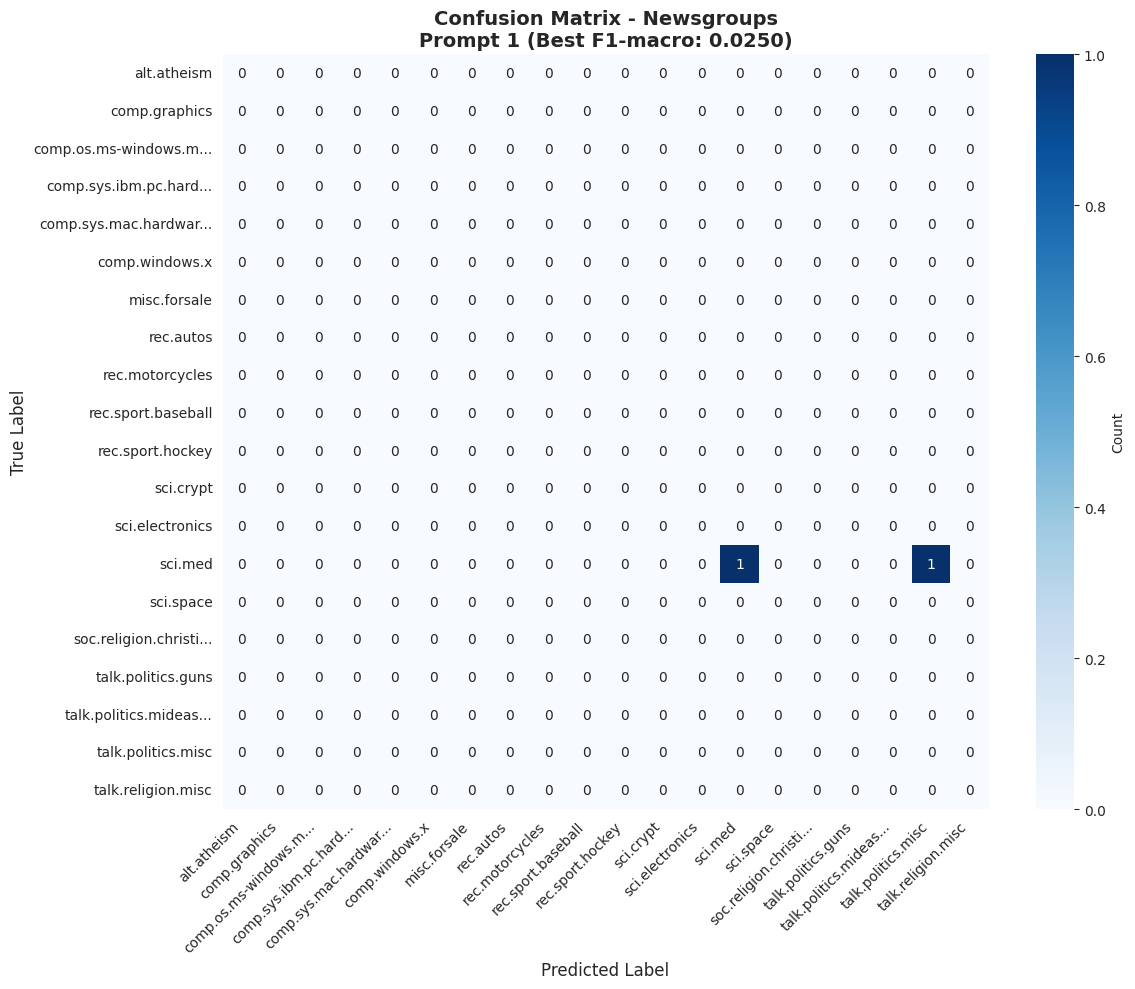


Confusion Matrix (Prompt 1 - Newsgroups):
Labels: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
alt.atheism,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
comp.graphics,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
comp.os.ms-windows.misc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
comp.sys.ibm.pc.hardware,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
comp.sys.mac.hardware,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
comp.windows.x,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
misc.forsale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
rec.autos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
rec.motorcycles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
rec.sport.baseball,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



Per-class metrics:
  alt.atheism: Precision=0.000, Recall=0.000, F1=0.000
  comp.graphics: Precision=0.000, Recall=0.000, F1=0.000
  comp.os.ms-windows.misc: Precision=0.000, Recall=0.000, F1=0.000
  comp.sys.ibm.pc.hardware: Precision=0.000, Recall=0.000, F1=0.000
  comp.sys.mac.hardware: Precision=0.000, Recall=0.000, F1=0.000
  comp.windows.x: Precision=0.000, Recall=0.000, F1=0.000
  misc.forsale: Precision=0.000, Recall=0.000, F1=0.000
  rec.autos: Precision=0.000, Recall=0.000, F1=0.000
  rec.motorcycles: Precision=0.000, Recall=0.000, F1=0.000
  rec.sport.baseball: Precision=0.000, Recall=0.000, F1=0.000
  rec.sport.hockey: Precision=0.000, Recall=0.000, F1=0.000
  sci.crypt: Precision=0.000, Recall=0.000, F1=0.000
  sci.electronics: Precision=0.000, Recall=0.000, F1=0.000
  sci.med: Precision=1.000, Recall=0.500, F1=0.667
  sci.space: Precision=0.000, Recall=0.000, F1=0.000
  soc.religion.christian: Precision=0.000, Recall=0.000, F1=0.000
  talk.politics.guns: Precision=0.000,

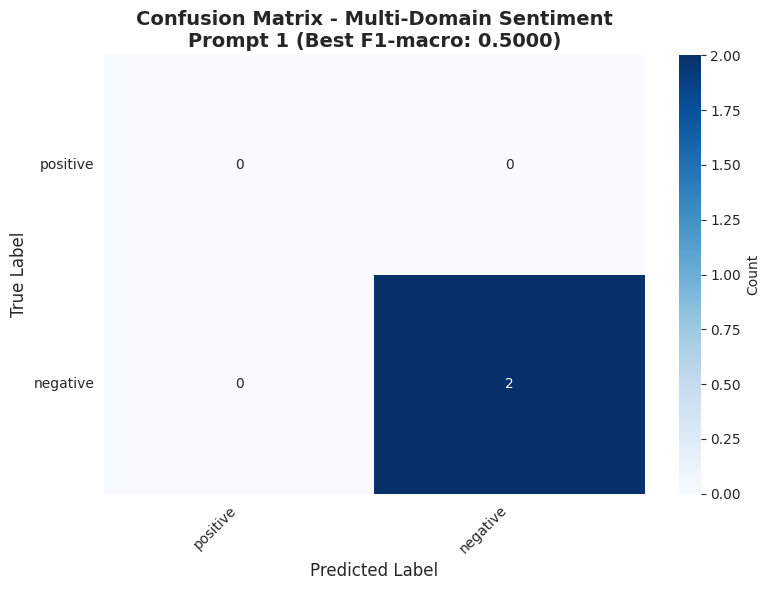


Confusion Matrix (Prompt 1 - Multi-Domain Sentiment):
Labels: ['positive', 'negative']


,positive,negative
positive,0,0
negative,0,2



Per-class metrics:
  positive: Precision=0.000, Recall=0.000, F1=0.000
  negative: Precision=1.000, Recall=1.000, F1=1.000

INFERENCE TIME SUMMARY
Total inference time: 114.01 seconds
Formatted: 0h 1m 54s 7ms


In [22]:
print("\n"+"="*100)
print("CONFUSION MATRICES")
print("="*100)

# Generar matrices de confusión para el mejor prompt de cada dataset
for dataset_name in ["Newsgroups", "Multi-Domain Sentiment"]:
    dataset_df = grouped_summary[grouped_summary["dataset"] == dataset_name]
    if len(dataset_df) == 0:
        continue
    
    # Encontrar el mejor prompt (mayor f1_macro)
    best_prompt_row = dataset_df.loc[dataset_df["f1_macro"].idxmax()]
    best_prompt = int(best_prompt_row["prompt"])
    
    print(f"\n{'='*100}")
    print(f"Dataset: {dataset_name} - Best Prompt: {best_prompt} (F1-macro: {best_prompt_row['f1_macro']:.4f})")
    print(f"{'='*100}")
    
    if best_prompt not in confusion_data[dataset_name]:
        print(f"No data available for prompt {best_prompt}")
        continue
    
    # Combinar predicciones de todos los modelos para este prompt
    all_y_true = []
    all_y_pred = []
    for model_name, (y_true, y_pred) in confusion_data[dataset_name][best_prompt].items():
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)
    
    # Obtener labels según el dataset
    if dataset_name == "Newsgroups":
        labels = NEWS_LABELS
    else:
        labels = MULTI_LABELS
    
    # Generar matriz de confusión
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    
    # Crear visualización
    plt.figure(figsize=(12, 10) if dataset_name == "Newsgroups" else (8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[l[:20] + '...' if len(l) > 20 else l for l in labels],
                yticklabels=[l[:20] + '...' if len(l) > 20 else l for l in labels],
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {dataset_name}\nPrompt {best_prompt} (Best F1-macro: {best_prompt_row["f1_macro"]:.4f})', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # También mostrar como tabla de texto
    print(f"\nConfusion Matrix (Prompt {best_prompt} - {dataset_name}):")
    print(f"Labels: {labels}")
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    display(cm_df)
    
    # Calcular métricas por clase
    print(f"\nPer-class metrics:")
    for i, label in enumerate(labels):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - tp - fp - fn
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"  {label}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

# ======================================================================
# TIEMPO TOTAL DE INFERENCIA
# ======================================================================
end_time = time.time()
total_time = end_time - start_time
hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
seconds = int(total_time % 60)
milliseconds = int((total_time % 1) * 1000)

print("\n"+"="*100)
print("INFERENCE TIME SUMMARY")
print("="*100)
print(f"Total inference time: {total_time:.2f} seconds")
print(f"Formatted: {hours}h {minutes}m {seconds}s {milliseconds}ms")
print("="*100)

---

## Análisis y Discusión

* Compare el desempeño entre encoders y decoders para cada dataset y tarea.

* Analice la robustez de cada enfoque frente a la variabilidad de los datos.

* Discuta las ventajas y limitaciones de cada paradigma en términos de:

  * Facilidad de uso y ajuste
  * Requerimientos computacionales
  * Interpretabilidad
  * Adaptabilidad a nuevas tareas o dominios

* Justifique la selección de prompts y analice la sensibilidad de los resultados frente a su formulación.

* Incluya un apartado de recomendaciones sobre el uso de encoders y decoders para tareas de clasificación de texto en función de los resultados obtenidos.

---


## Entrega

* Suba todos los notebooks, el informe PDF y los archivos necesarios a la plataforma indicada.

* No envíe la tarea por correo electrónico.

---

## Notas

* Se valorará el rigor experimental, la claridad en la justificación de las decisiones tomadas y la profundidad del análisis comparativo.

* Puede apoyarse en Transformers de HuggingFace y librerías asociadas.

* Si utiliza recursos computacionales limitados, puede reducir el tamaño del conjunto de datos o el número de épocas, pero debe justificarlo adecuadamente.

---